In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots
from tasks.boston_housing import make_task4 as make_task
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import shap
from shap.plots import bar
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names, name_b='C')

In [3]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [4]:
def load(focus_class):
    with open(f'explanations/clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           categorical_features=categorical_features,
                           feature_precisions=feature_precisions, state=state)
    return node

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [01:44,  2.23it/s]                         
Exact explainer: 247it [01:39,  2.22it/s]                         
Exact explainer: 247it [07:25,  1.86s/it]                         

CPU times: user 12min 7s, sys: 2min 13s, total: 14min 20s
Wall time: 10min 50s


In [6]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
CPU times: user 23min 11s, sys: 8.19 s, total: 23min 20s
Wall time: 23min 55s


# Individual Explanations

In [109]:
with open('explanations/indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

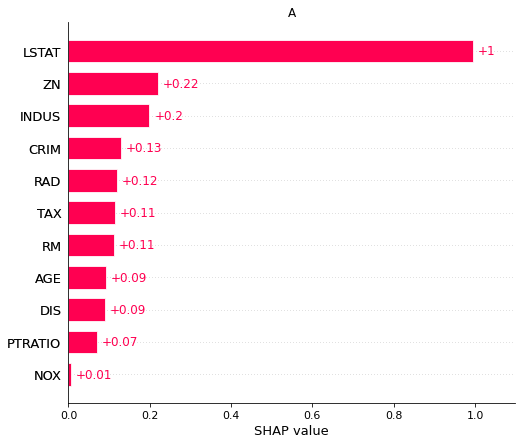

In [110]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

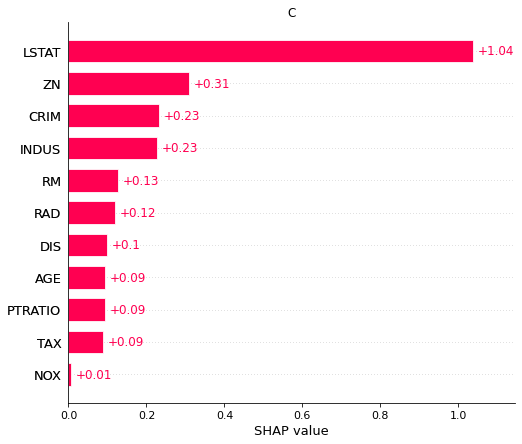

In [111]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['C.0', 'C.1', 'C.2']])
plot_feature_importance_bar(feature_importance, 'C', feature_order)
with open('../explanations/featimp-c.pickle', 'wb') as f:
    pickle.dump(feature_importance.values, f)

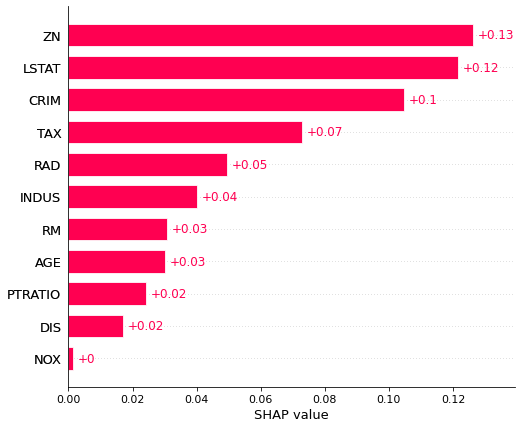

In [112]:
differences = indiv_shap_values[:, :, [label for label in indiv_shap_values.output_names if label.startswith('C.')]] -\
              indiv_shap_values[:, :, [label for label in indiv_shap_values.output_names if label.startswith('A.')]]
feature_order, feature_importance = calc_feature_order(differences)
plot_feature_importance_bar(feature_importance, feature_order=feature_order)
plt.savefig('figures/boston4-diff-feat-imp.pdf', bbox_inches='tight')

In [113]:
node = make_clustering(comparer, indiv_shap_values, categorical_features=categorical_features)

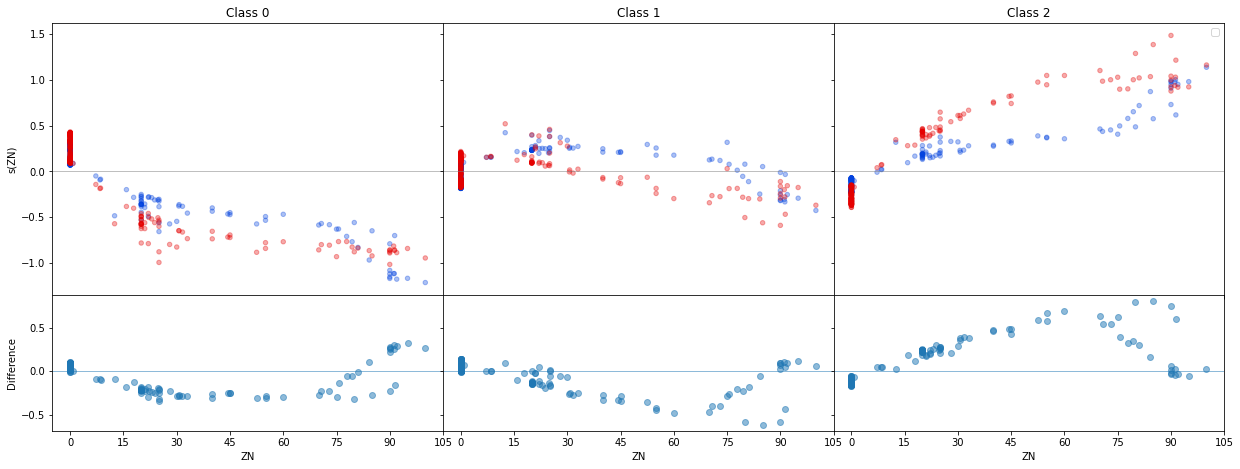

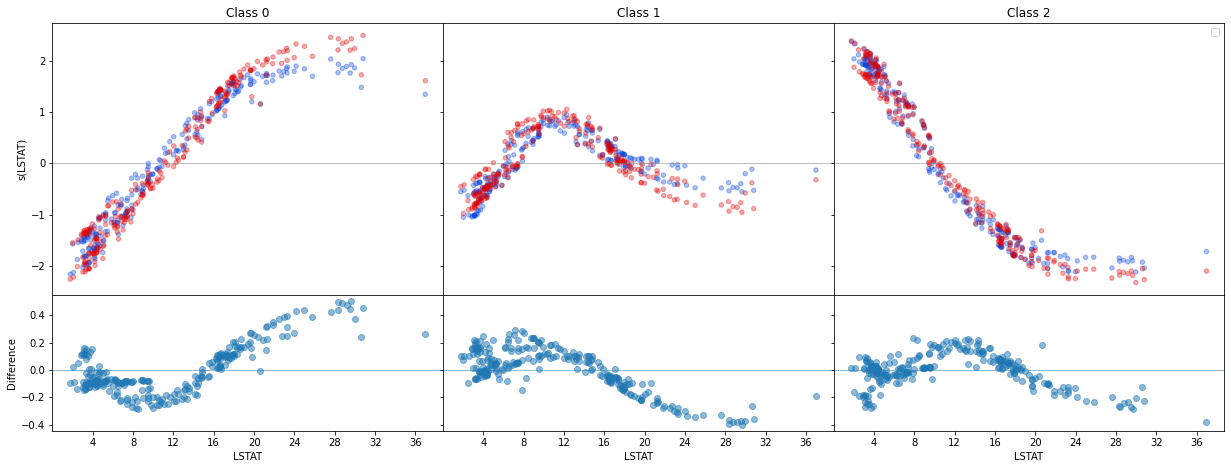

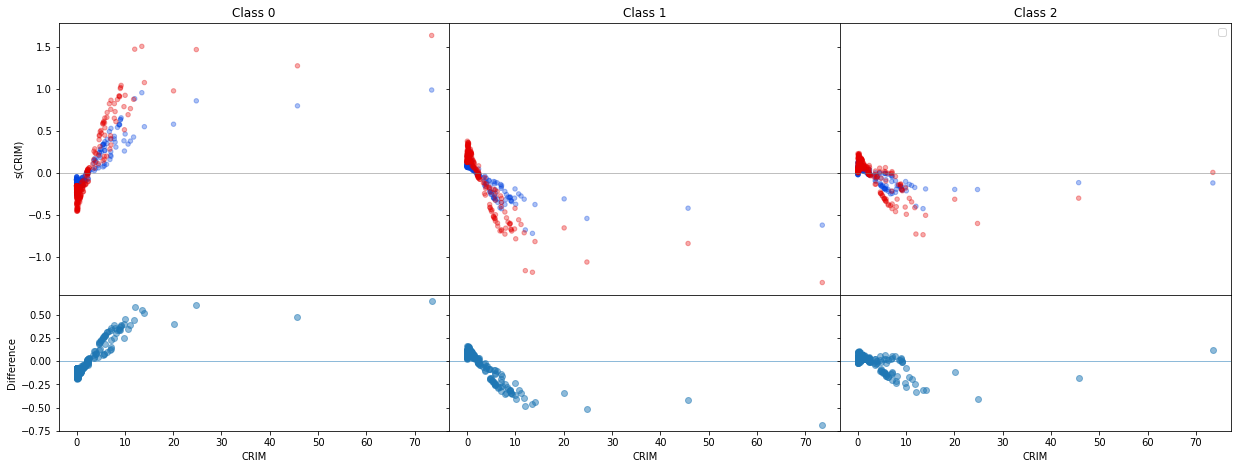

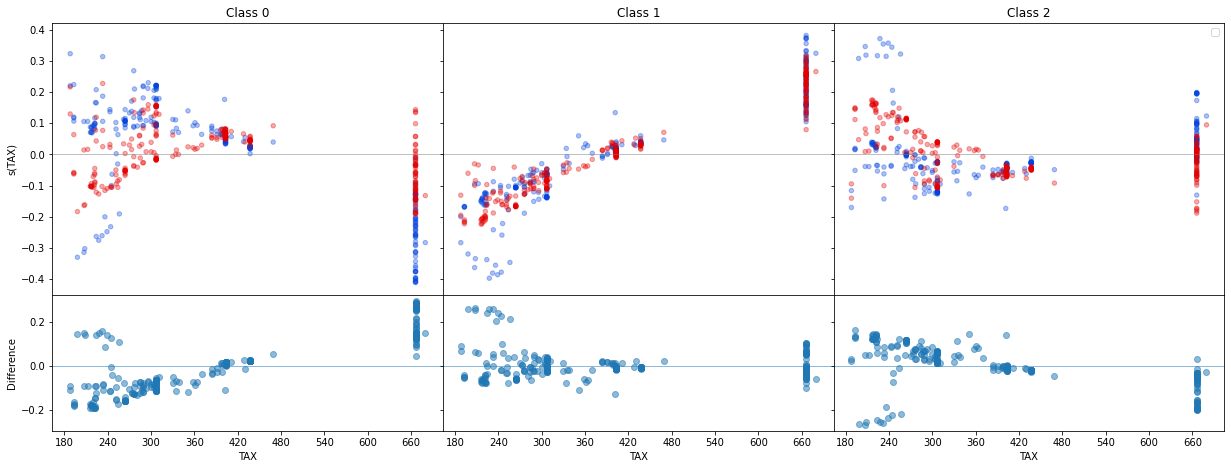

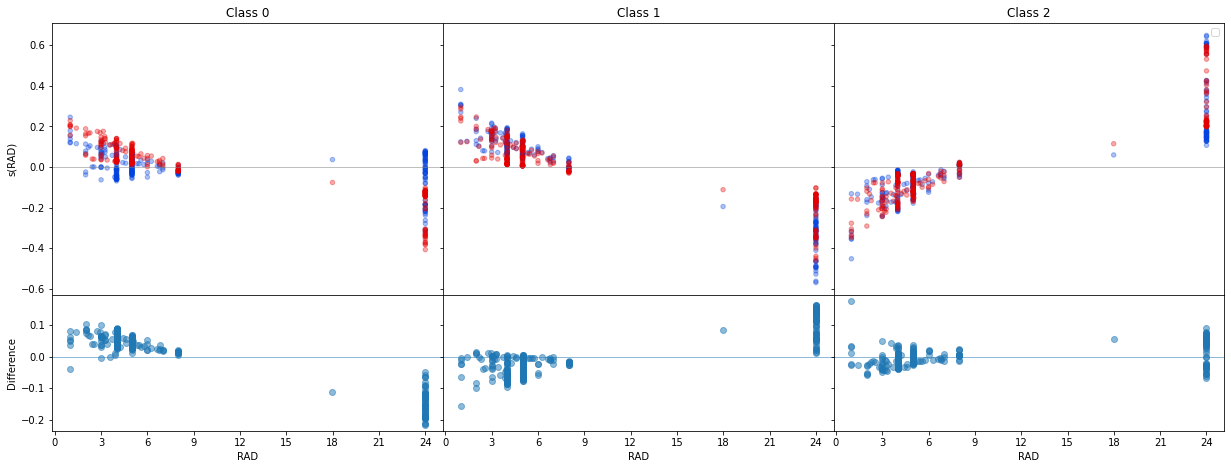

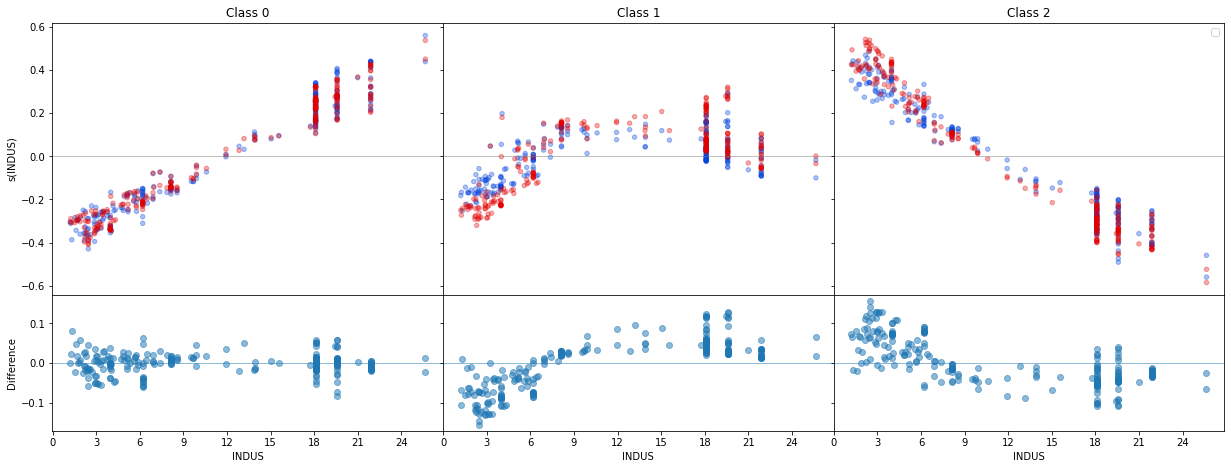

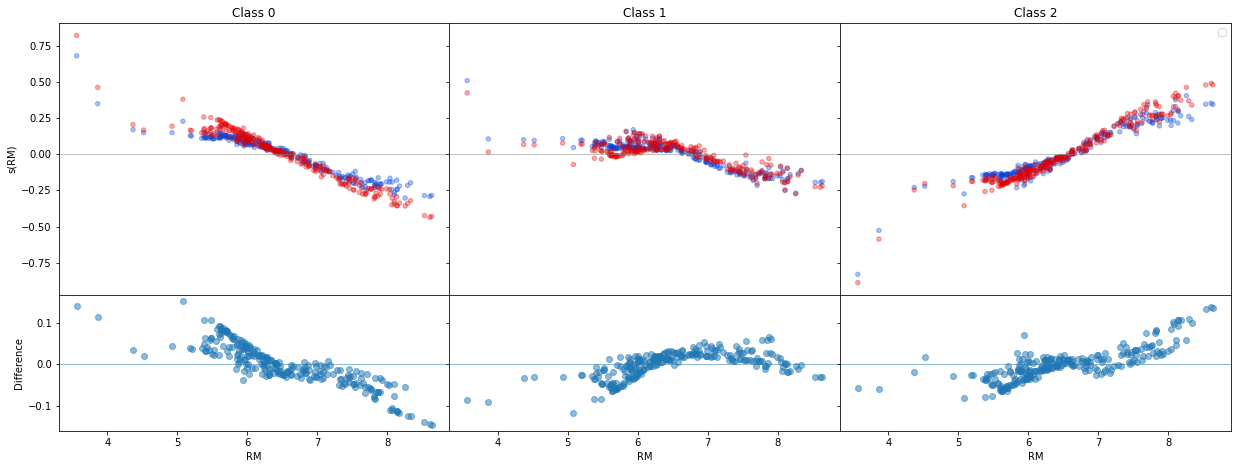

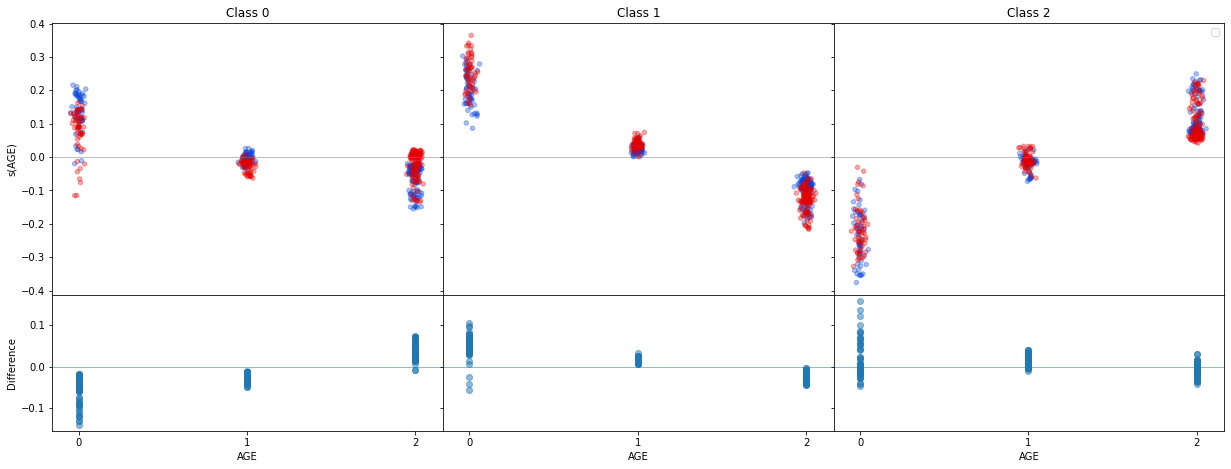

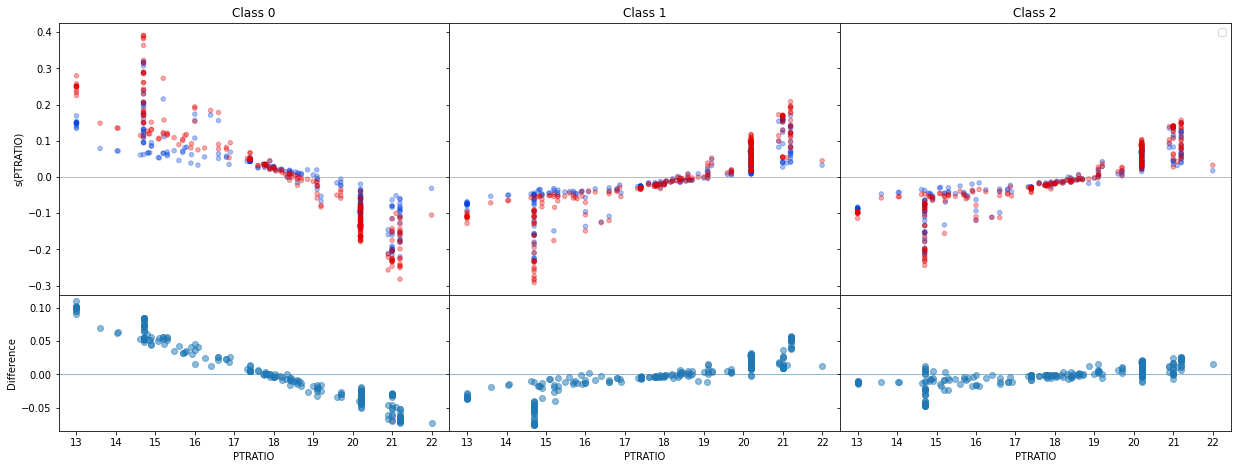

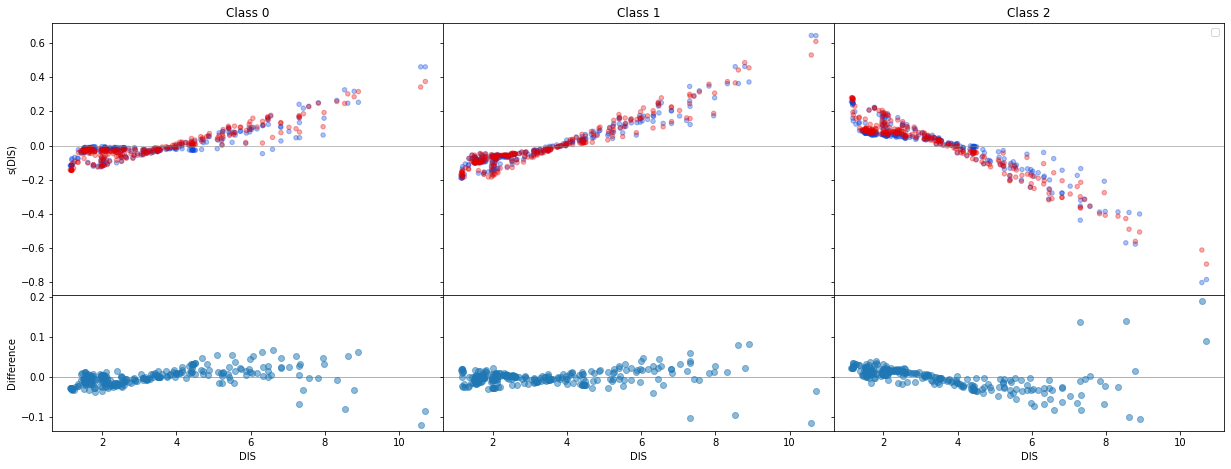

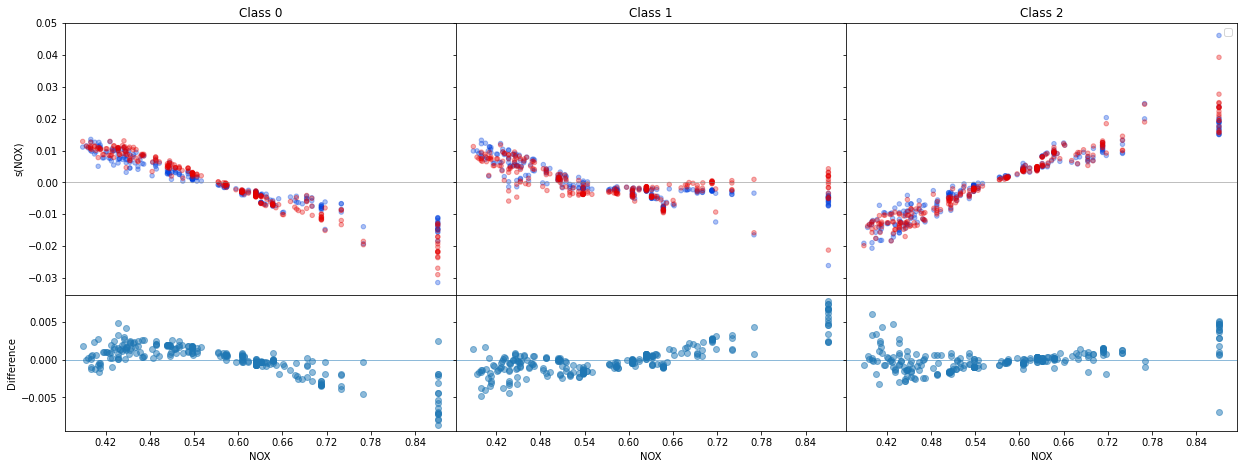

In [114]:
for feature in feature_names[feature_order]:
    compare_indiv_dep_plots(node, feature)
    plt.show()

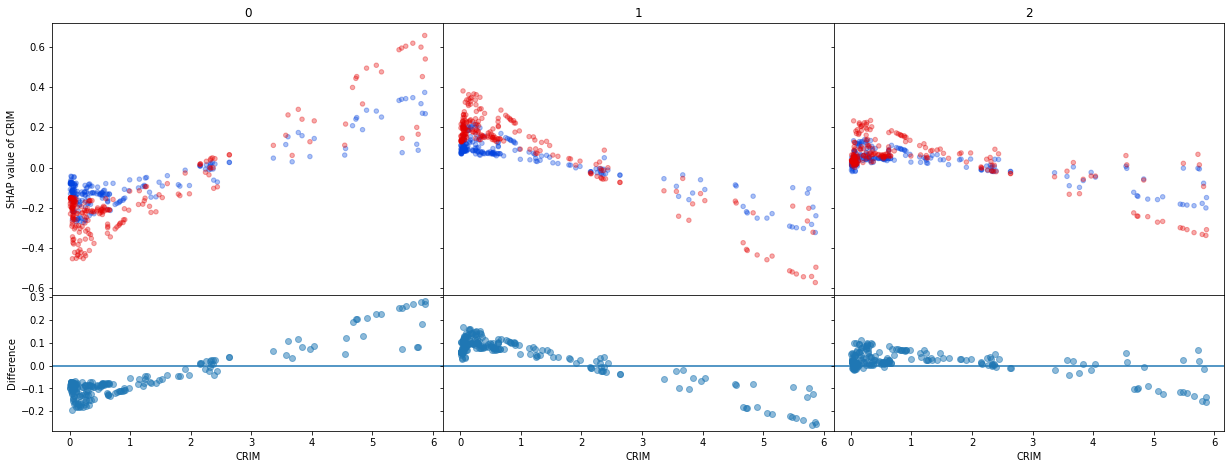

In [14]:
compare_indiv_dep_plots(node.filter('CRIM < 6'), 'CRIM')

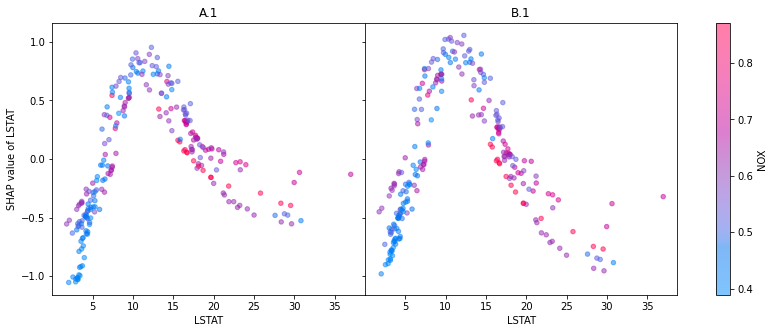

In [45]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.1'], 'LSTAT')
node.plot_feature_dependence('LSTAT', classes=['A.1', 'C.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

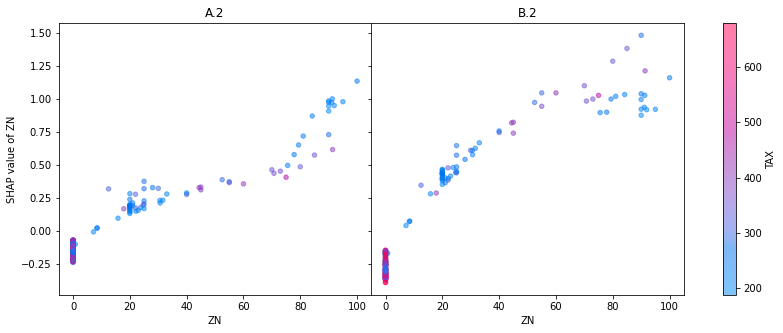

In [73]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.2'], 'ZN')
node.plot_feature_dependence('ZN', classes=['A.2', 'C.2'], alpha=0.5,
                             color='TAX')

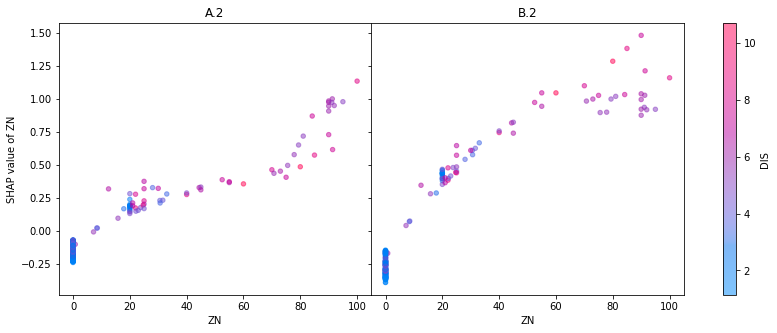

In [71]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.2'], 'ZN')
node.plot_feature_dependence('ZN', classes=['A.2', 'C.2'], alpha=0.5,
                             color='DIS')

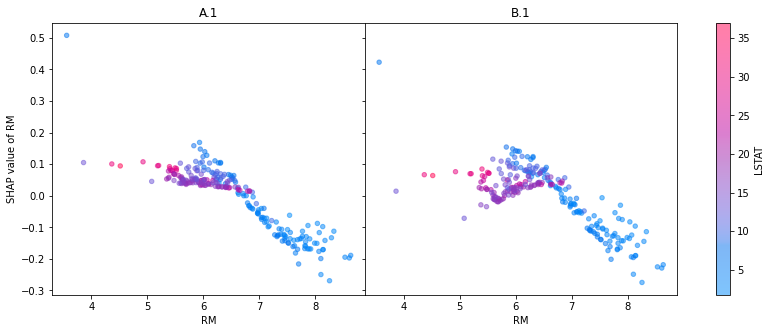

In [47]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.1'], 'RM')
node.plot_feature_dependence('RM', classes=['A.1', 'C.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

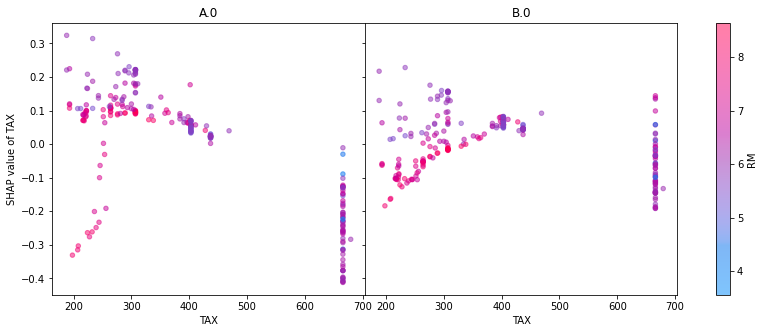

In [27]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.0'], 'TAX')
node.plot_feature_dependence('TAX', classes=['A.0', 'C.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

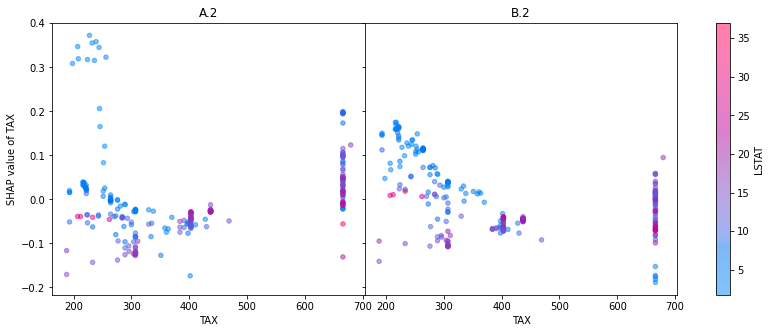

In [28]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.2'], 'TAX')
node.plot_feature_dependence('TAX', classes=['A.2', 'C.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

The vertical spread in the dependence plots of DIS suggests that interactions are present, but more important it looks like the interactions cause different DIS effects.

The SHAP package can estimate interactions based on correlation.

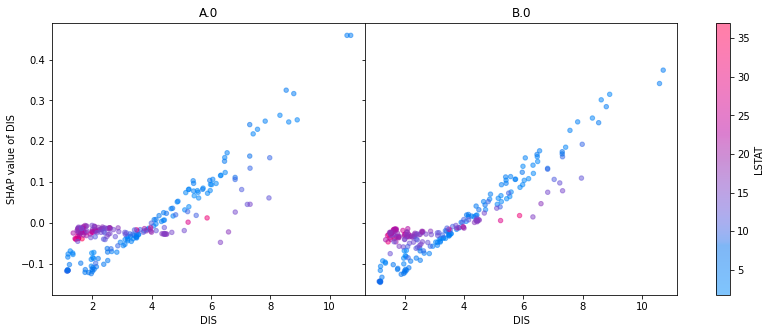

In [49]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.0'], 'DIS')
node.plot_feature_dependence('DIS', classes=['A.0', 'C.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

The strongest interactions are with feature LSTAT, clearly instances with medium to high LSTAT values yield different effects of feature DIS than with low values.

For AGE too, LSTAT mainly accounts for the vertical spread.

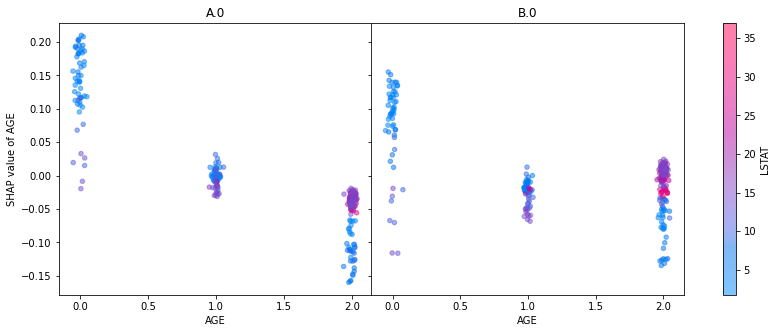

In [26]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.0'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.0', 'C.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

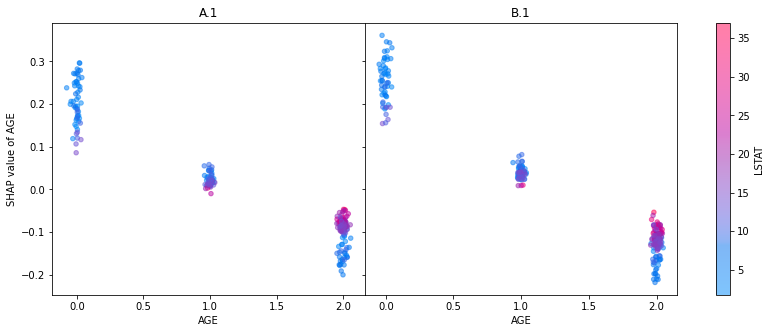

In [27]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.1'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.1', 'C.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

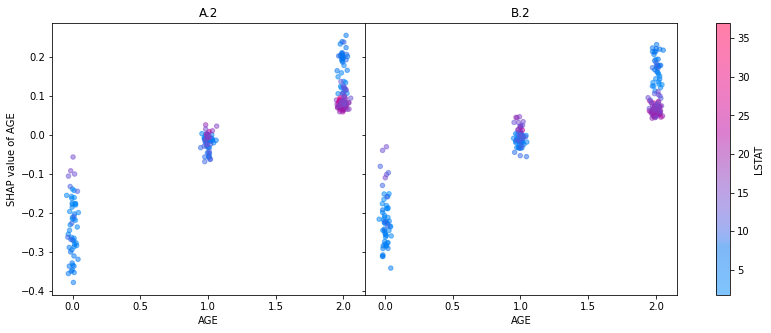

In [28]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'C.2'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.2', 'C.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

# Difference Classifier Explanations

In [5]:
with open('explanations/diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

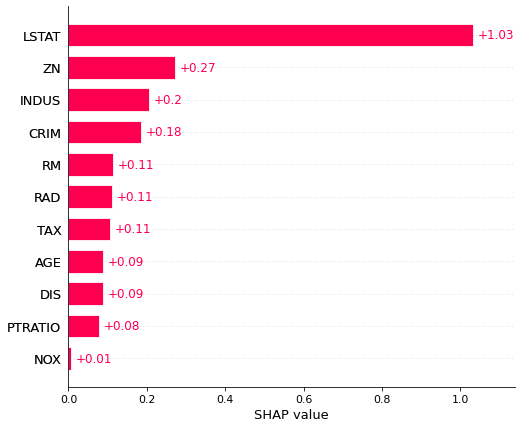

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## $(0,1)$

In [10]:
node = load('(0, 1)')
node.class_counts, node.distance
classes = ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']

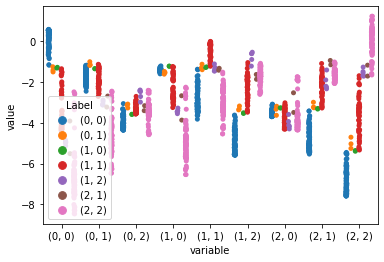

In [11]:
node.plot_outcomes()

In [12]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRR,
 (1, 1)    17
 (0, 0)     8
 (0, 1)     3
 (1, 0)     2
 dtype: int64,
 21.950278876066292)

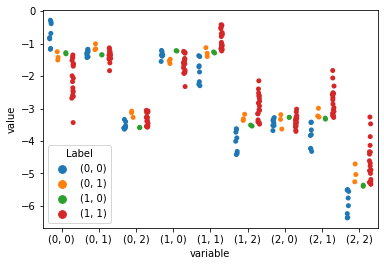

In [13]:
node.plot_outcomes()

In [14]:
print(node.rule_from_counterfactuals()[0])

10.48 < LSTAT <= 14.89 and ZN <= 1 and 12.37 < INDUS <= 22.10 and CRIM <= 4.3 and 13.36 < PTRATIO <= 20.73 and 4.81 < RM <= 7.33 and AGE > 0 and DIS <= 6.59


11.1 <= LSTAT <= 14.19
[Lower CF: LSTAT == 10.48 --> {'(1, 1)': 3},
 Upper CF: LSTAT == 14.9 --> {'(0, 0)': 3}]


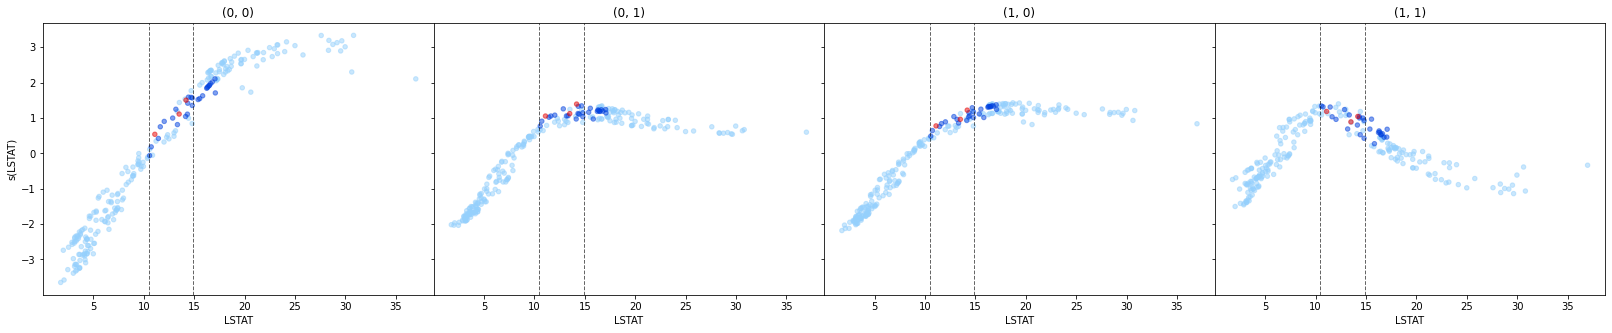

ZN == 0.0
[Upper CF: ZN == 2.0 --> {'(1, 1)': 3}]


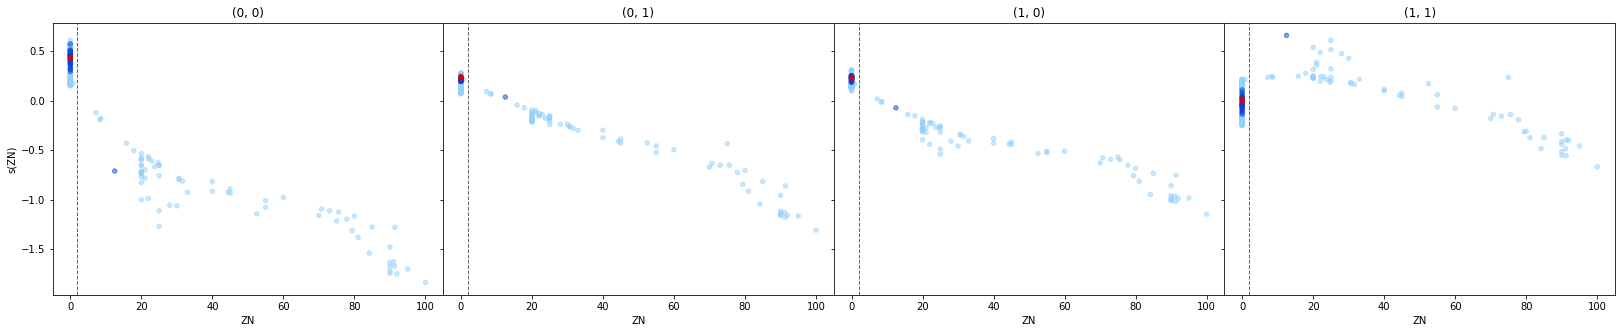

13.89 <= INDUS <= 19.58
[Lower CF: INDUS == 12.37 --> {'(1, 1)': 3},
 Upper CF: INDUS == 22.11 --> {'(0, 0)': 3}]


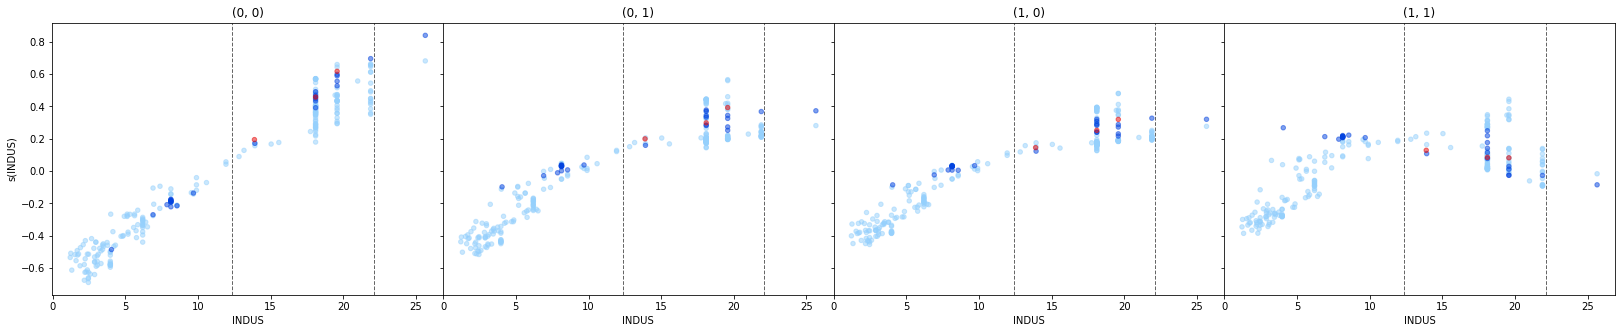

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 4.4 --> {'(0, 0)': 3}]


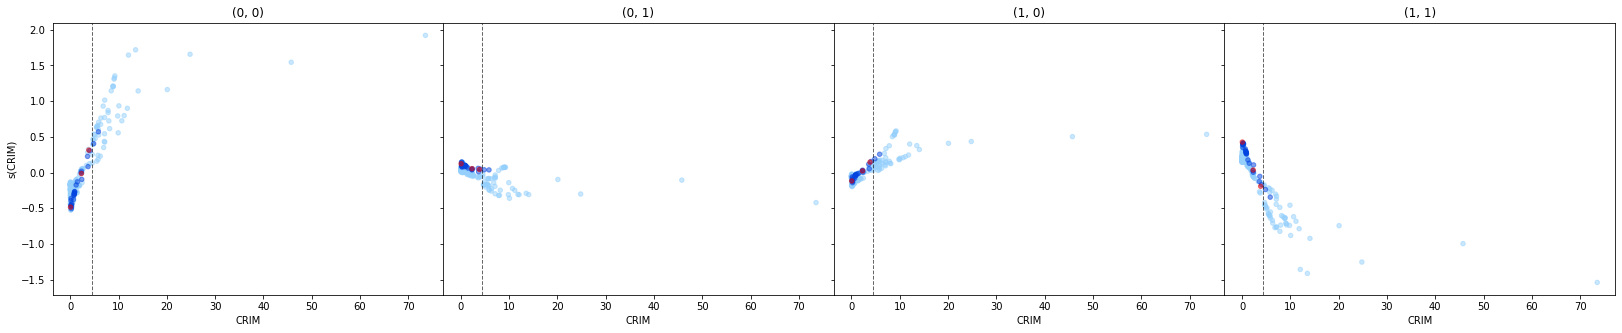

14.7 <= PTRATIO <= 20.2
[Lower CF: PTRATIO == 13.36 --> {'(0, 0)': 3},
 Upper CF: PTRATIO == 20.74 --> {'(1, 1)': 3}]


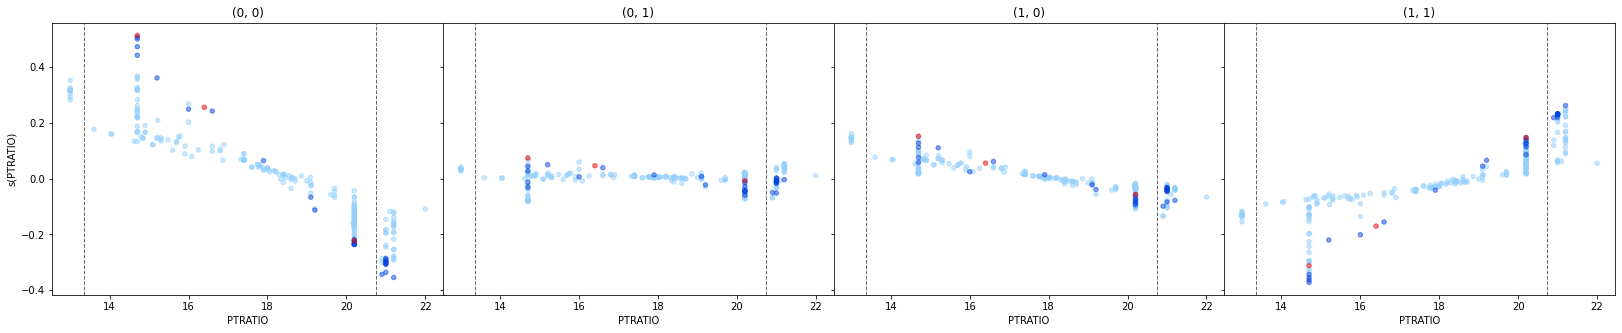

276.0 <= TAX <= 666.0
[]


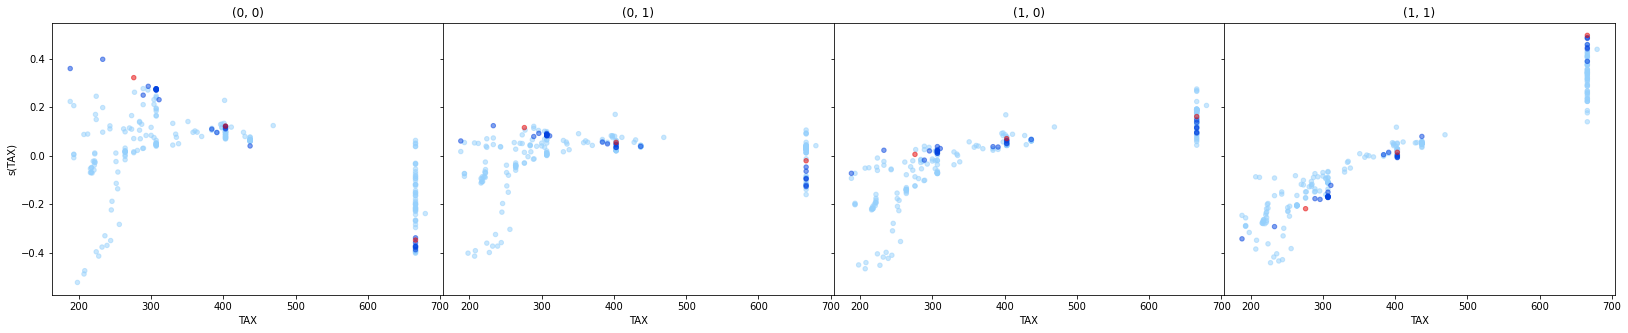

5.888 <= RM <= 6.319
[Lower CF: RM == 4.81 --> {'(0, 0)': 3}, Upper CF: RM == 7.34 --> {'(1, 1)': 3}]


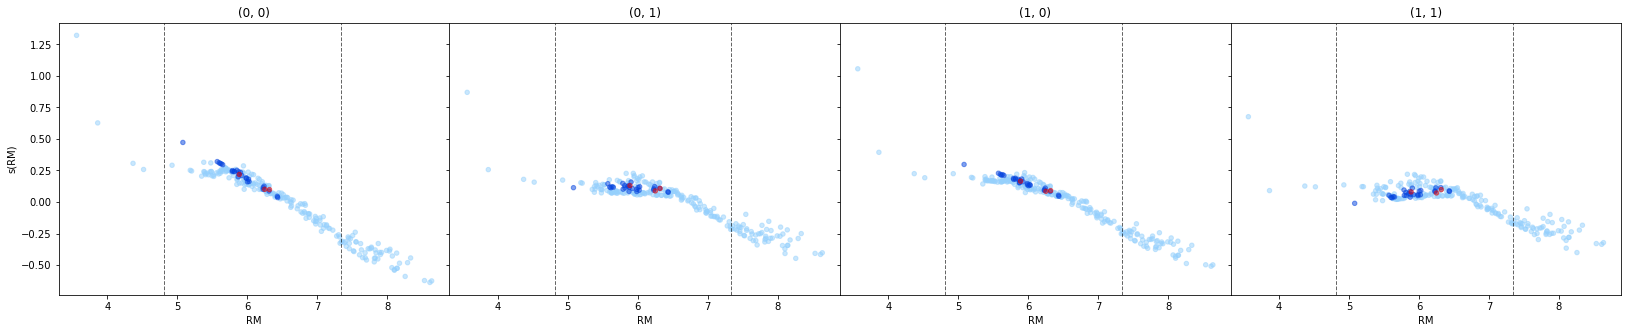

5.0 <= RAD
[]


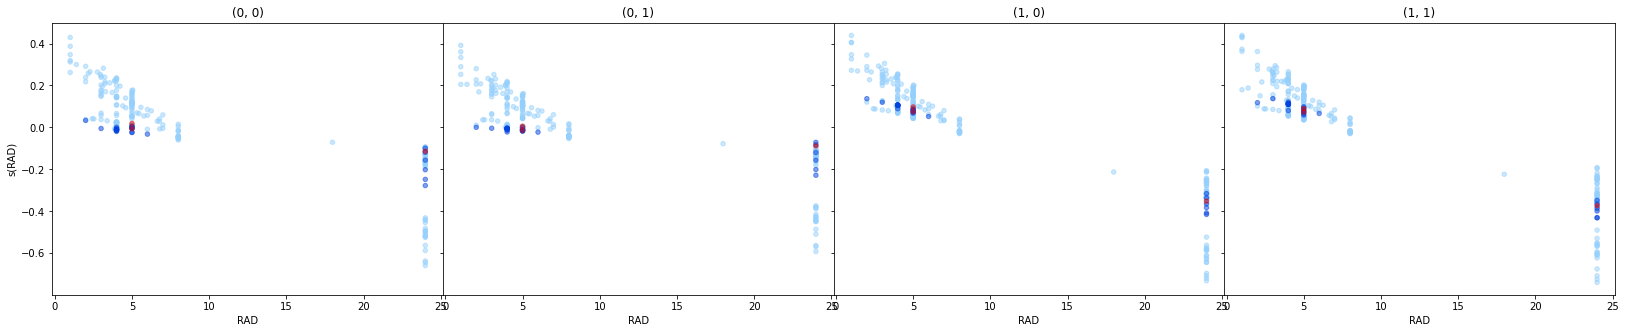

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 1)': 3}]


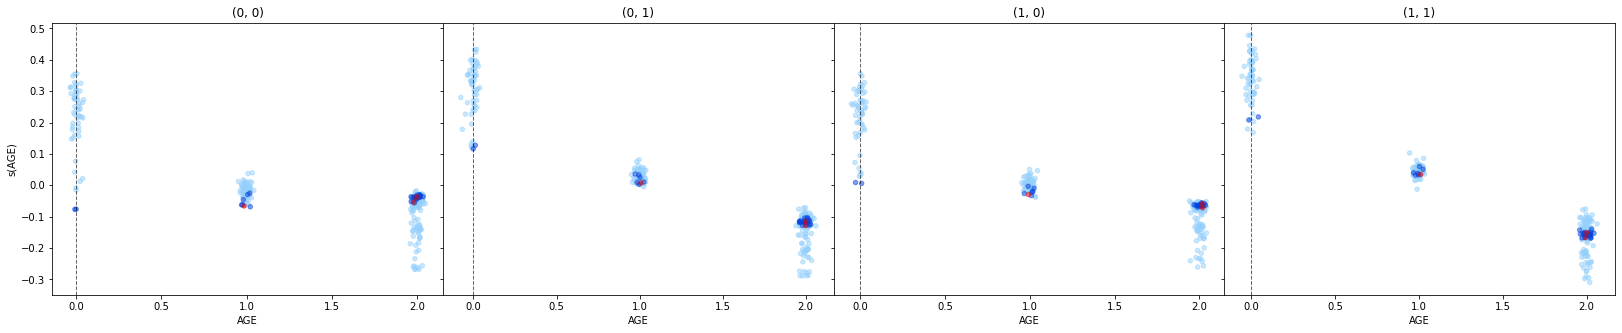

2.1 <= DIS <= 3.1121
[Upper CF: DIS == 6.6 --> {'(1, 1)': 3}]


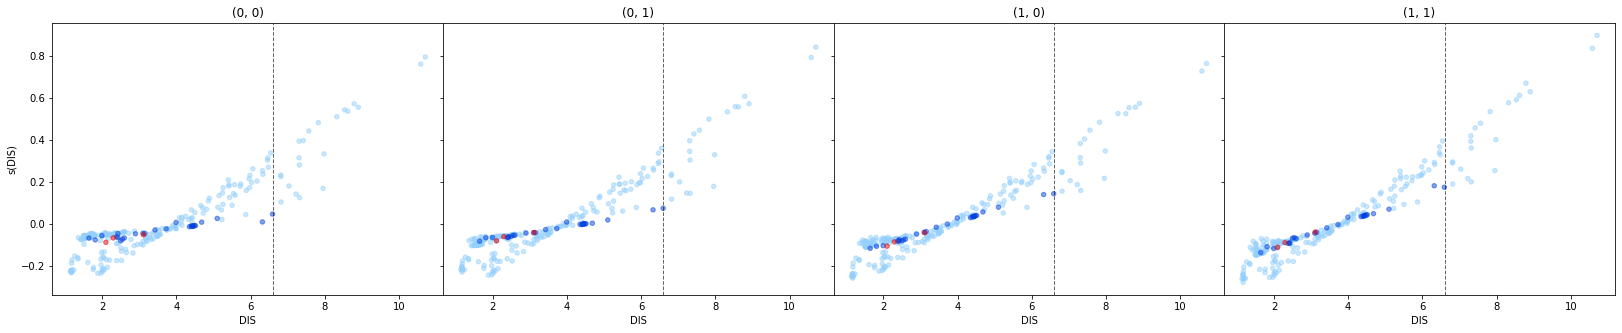

0.55 <= NOX <= 0.77
[]


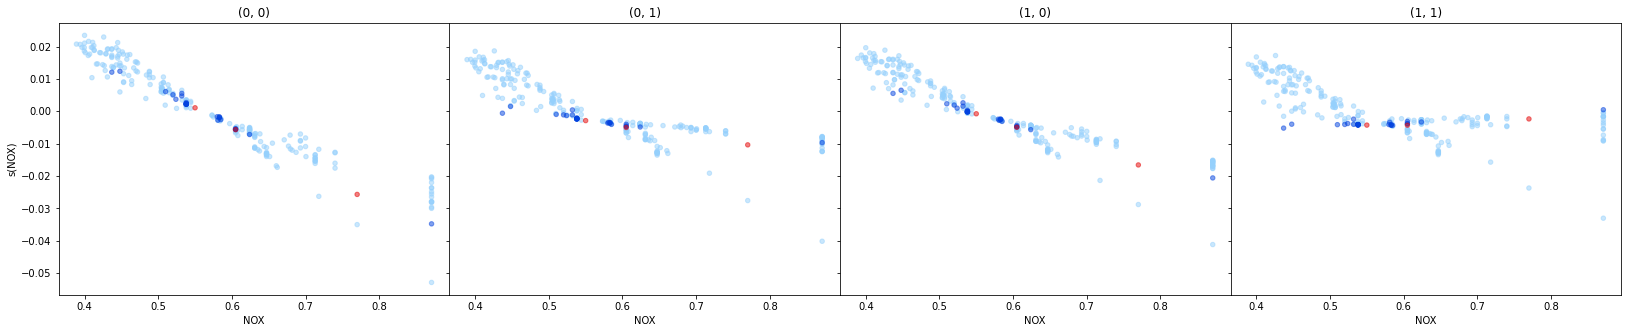

In [15]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True);

## $(1,0)$

In [7]:
node = load('(1, 0)')
classes = ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (1, 0)     2
 (2, 1)     2
 dtype: int64,
 149.33968539846273)

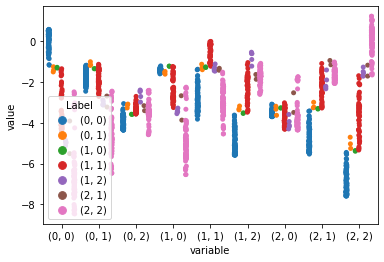

In [8]:
node.plot_outcomes()

In [9]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRRRRLRRLR,
 (1, 0)    2
 dtype: int64,
 0.001899920368762976)

In [10]:
node = node.parent
node, node.class_counts, node.distance

(LRRRRRLRRL,
 (1, 0)    2
 (1, 1)    1
 dtype: int64,
 0.03131691911091533)

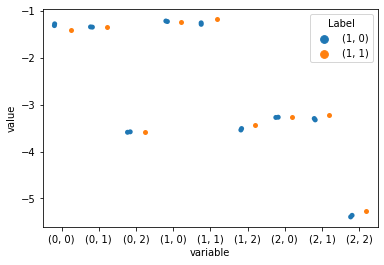

In [11]:
node.plot_outcomes()

In [12]:
print(node.rule_from_counterfactuals()[0])

16.33 < LSTAT <= 16.71 and ZN <= 0 and 0.6 < CRIM <= 1.1 and 20.58 < PTRATIO <= 21.38 and 7.13 < INDUS <= 9.14 and 5.22 < RM <= 5.75 and 288 < TAX <= 326 and AGE > 1 and RAD <= 5.93 and DIS > 2.93


16.476581495471024 <= LSTAT <= 16.51
[Lower CF: LSTAT == 16.33 --> {'(1, 1)': 2},
 Upper CF: LSTAT == 16.72 --> {'(0, 0)': 2}]


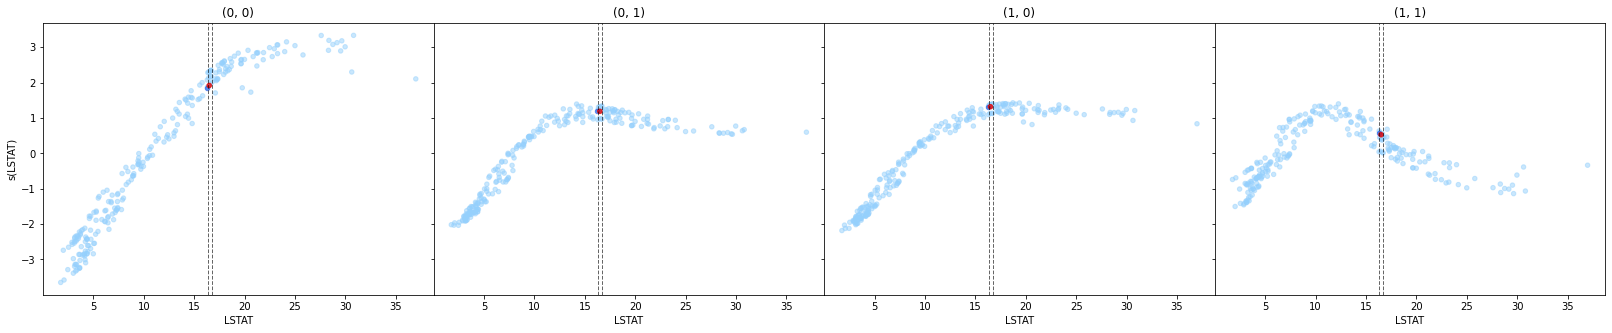

ZN == 0.0
[Upper CF: ZN == 1.0 --> {'(1, 1)': 2}]


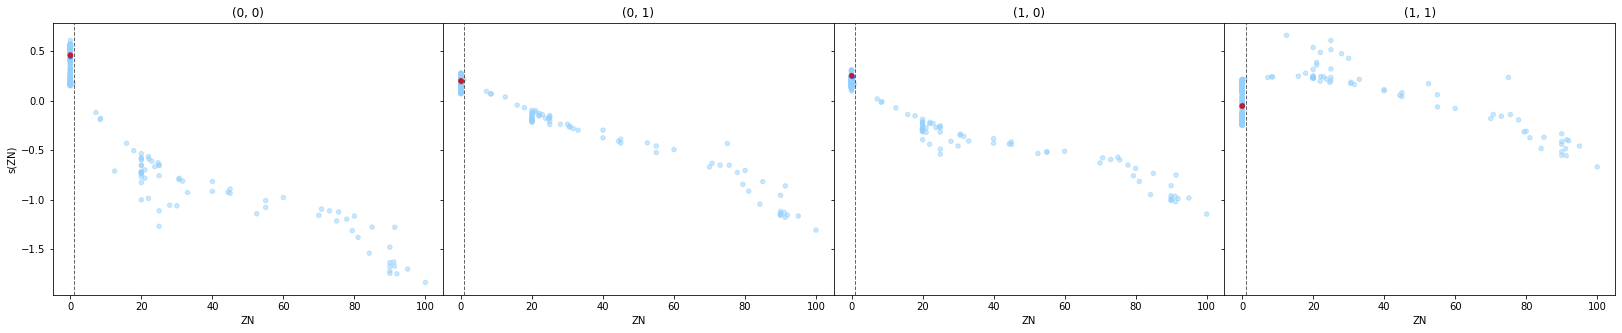

0.8261732257672565 <= CRIM <= 0.84054
[Lower CF: CRIM == 0.6 --> {'(1, 1)': 2},
 Upper CF: CRIM == 1.2 --> {'(0, 0)': 2}]


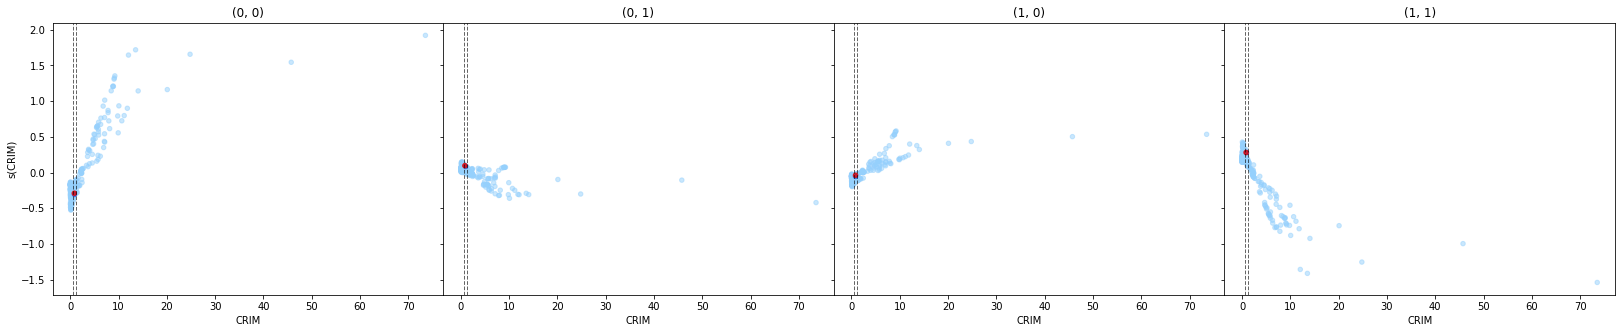

PTRATIO == 21.0
[Lower CF: PTRATIO == 20.58 --> {'(0, 0)': 2},
 Upper CF: PTRATIO == 21.39 --> {'(1, 1)': 2}]


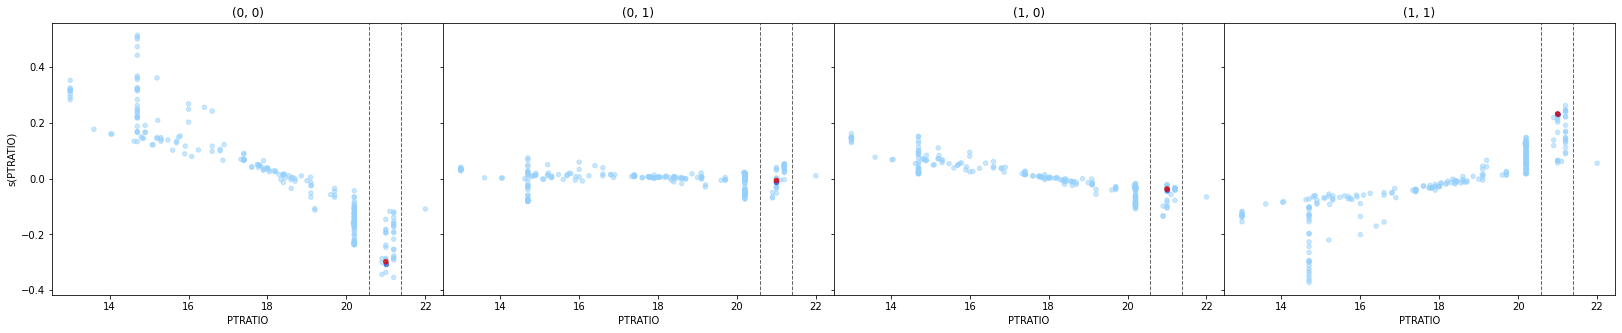

INDUS == 8.14
[Lower CF: INDUS == 7.13 --> {'(1, 1)': 2},
 Upper CF: INDUS == 9.15 --> {'(0, 0)': 2}]


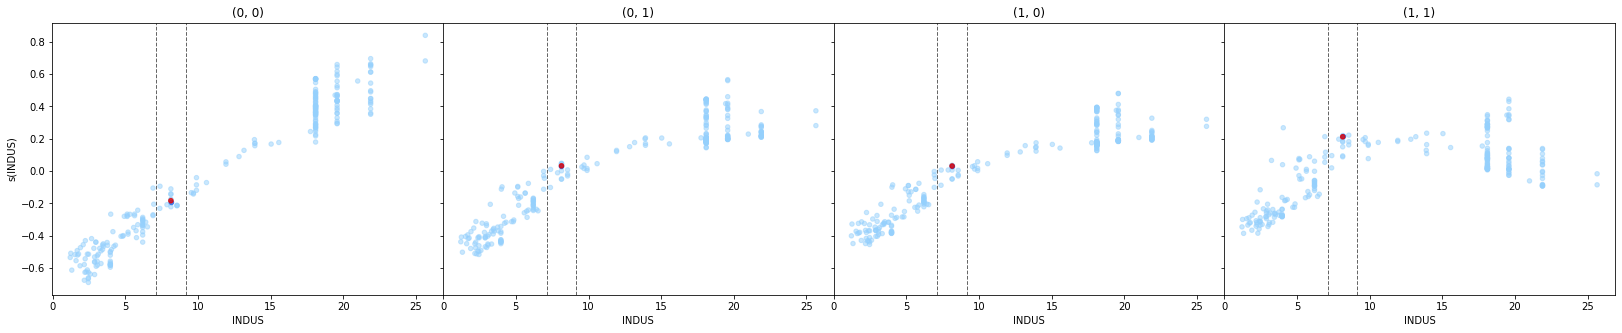

5.599 <= RM <= 5.65071911415199
[Lower CF: RM == 5.22 --> {'(0, 0)': 2}, Upper CF: RM == 5.76 --> {'(1, 1)': 2}]


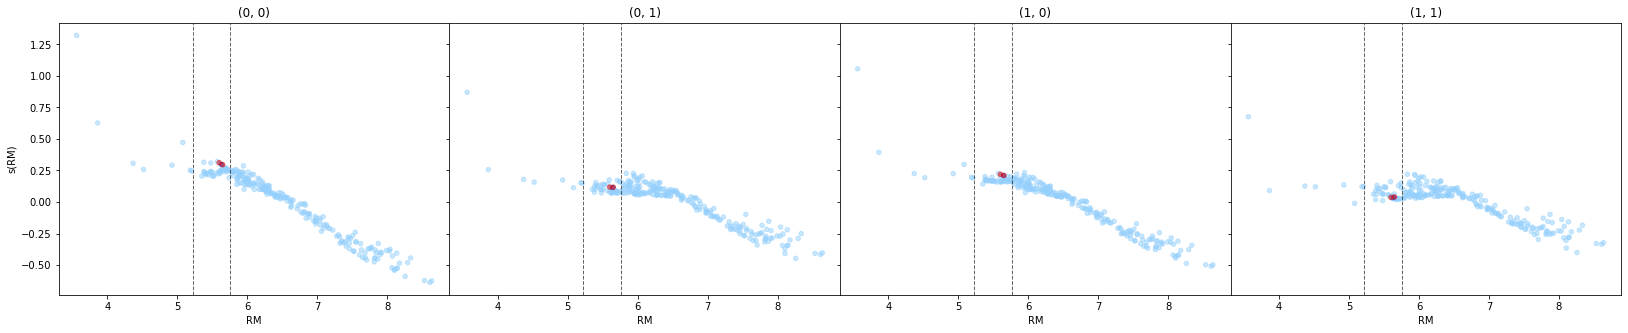

TAX == 307.0
[Lower CF: TAX == 288.0 --> {'(0, 0)': 2},
 Upper CF: TAX == 327.0 --> {'(1, 1)': 2}]


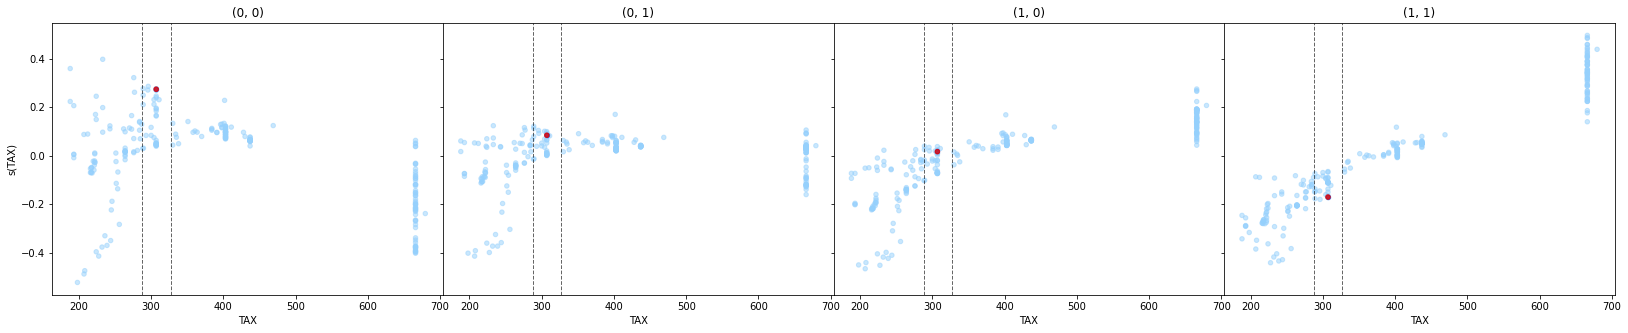

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 2}]


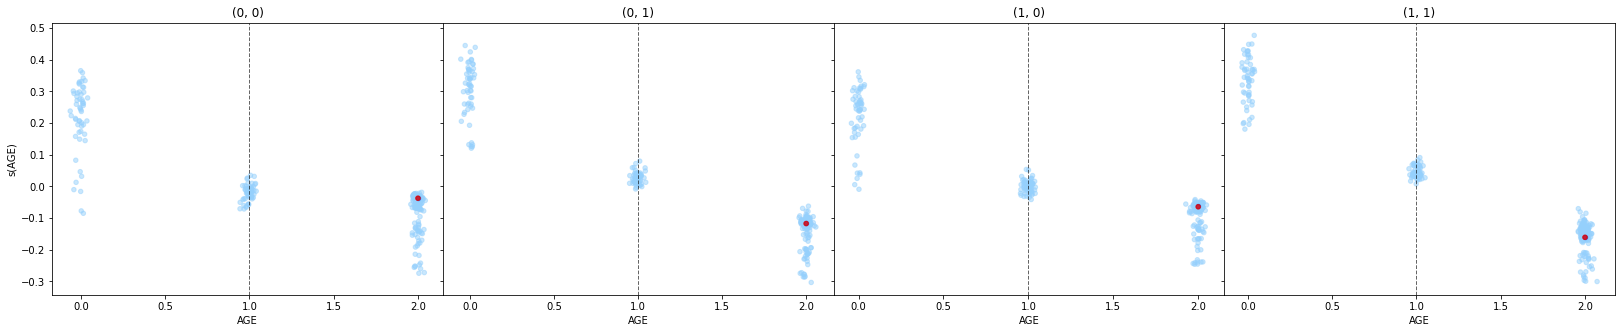

RAD == 4.0
[Upper CF: RAD == 5.94 --> {'(0, 0)': 2}]


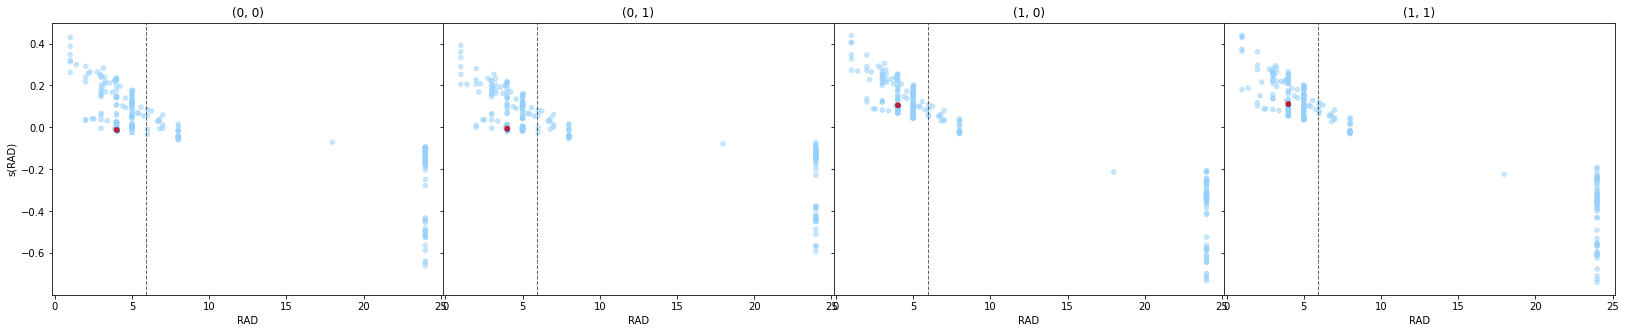

4.4458475345281245 <= DIS <= 4.4546
[Lower CF: DIS == 2.93 --> {'(1, 1)': 1, '(0, 0)': 1}]


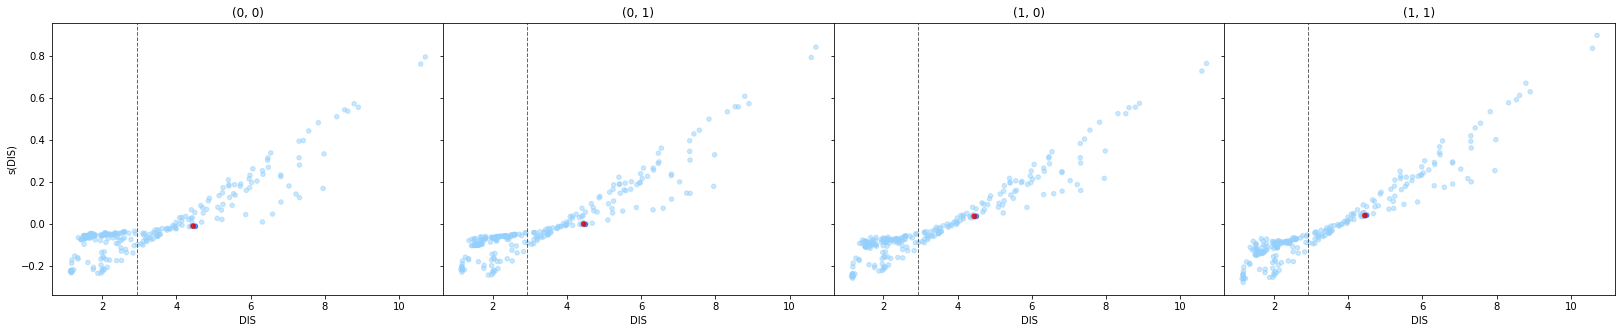

NOX == 0.538
[]


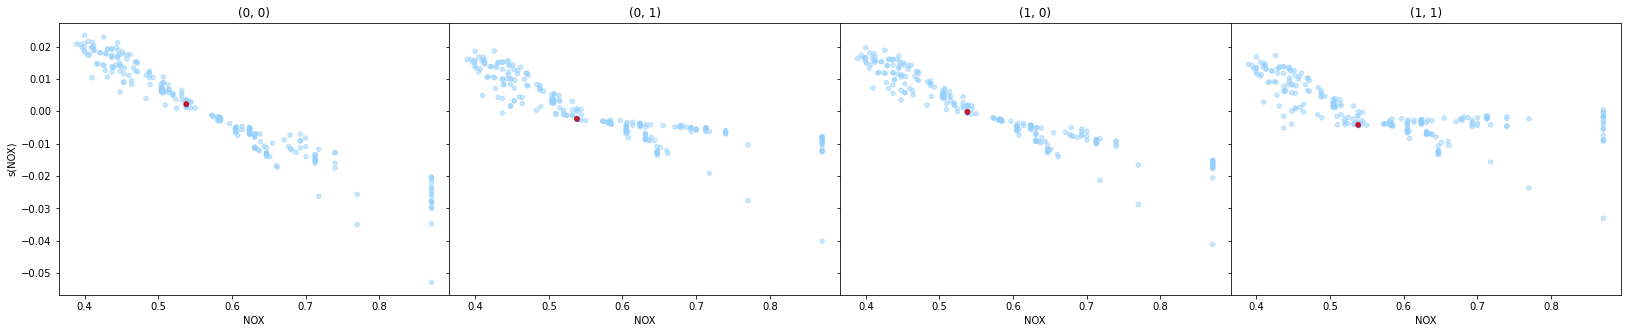

In [31]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True);

## $(1,2)$

In [32]:
node = load('(1, 2)')
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (1, 0)     2
 (2, 1)     2
 dtype: int64,
 149.33968539846273)

In [33]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(R,
 (2, 2)    96
 (1, 1)    35
 (1, 2)     5
 (2, 1)     2
 dtype: int64,
 80.73292334198608)

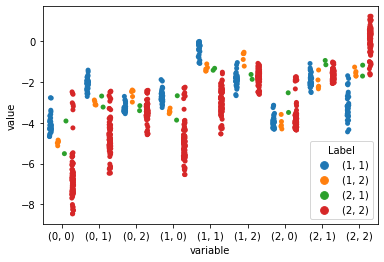

In [34]:
node.plot_outcomes()

In [35]:
print(node.rule_from_counterfactuals()[0])

3.58 < LSTAT <= 11.58 and ZN > 16 and INDUS <= 16.12 and CRIM <= 42.3 and RM <= 8.63 and RAD <= 13.35 and DIS > 1.94 and AGE <= 1


5.49 <= LSTAT <= 9.522242201272585
[Lower CF: LSTAT == 3.58 --> {'(2, 2)': 5},
 Upper CF: LSTAT == 11.59 --> {'(1, 1)': 5}]


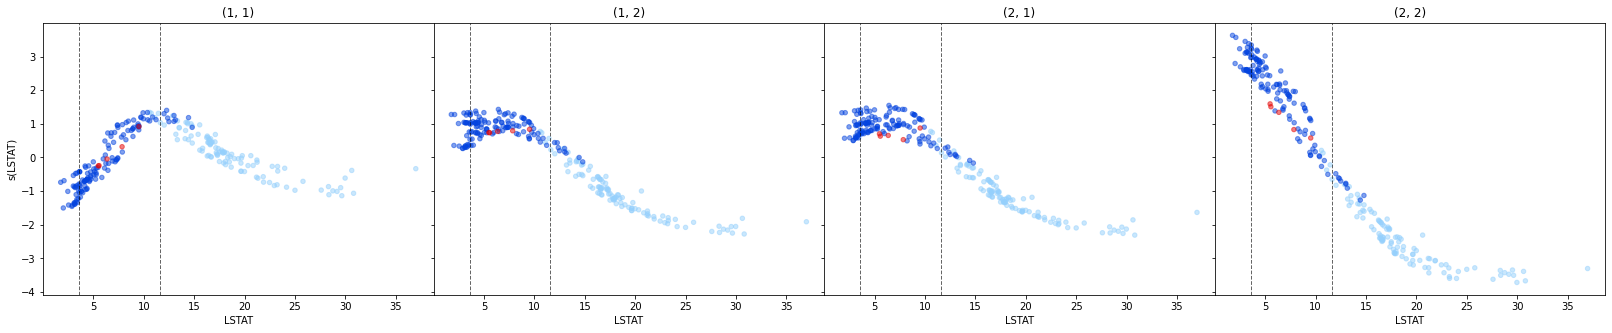

20.0 <= ZN <= 90.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 5}]


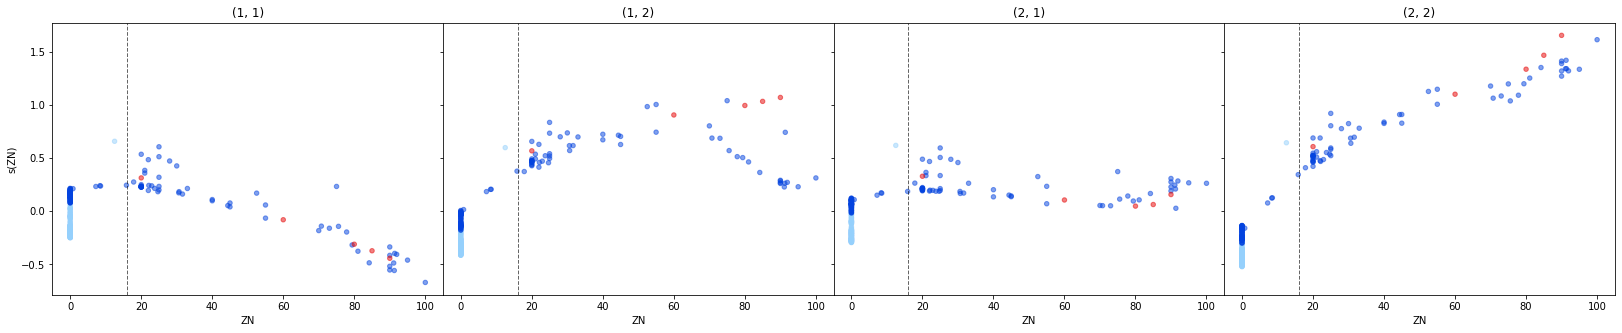

1.69 <= INDUS <= 4.15
[Upper CF: INDUS == 16.13 --> {'(1, 1)': 5}]


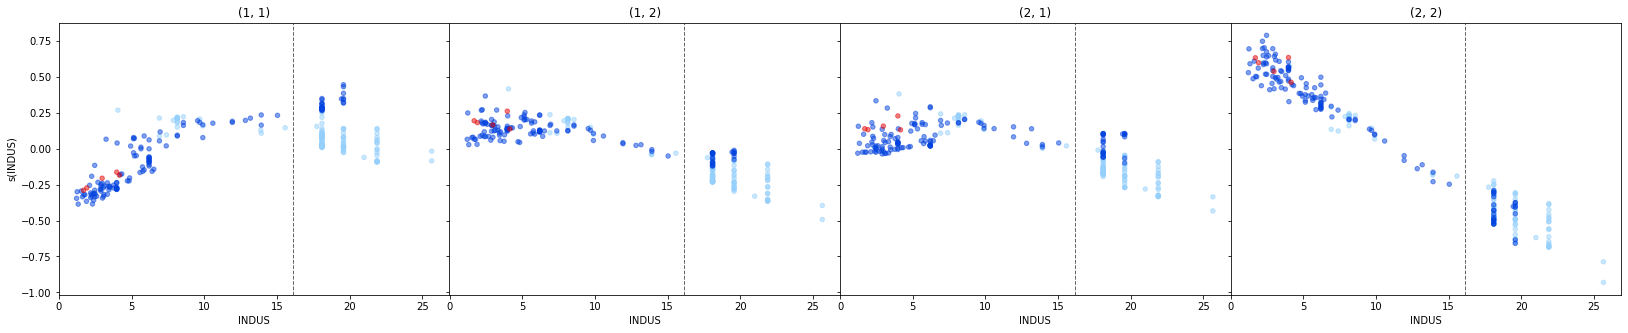

CRIM <= 0.539742303467232
[Upper CF: CRIM == 42.4 --> {'(2, 2)': 3, '(0, 0)': 1, '(1, 0)': 1}]


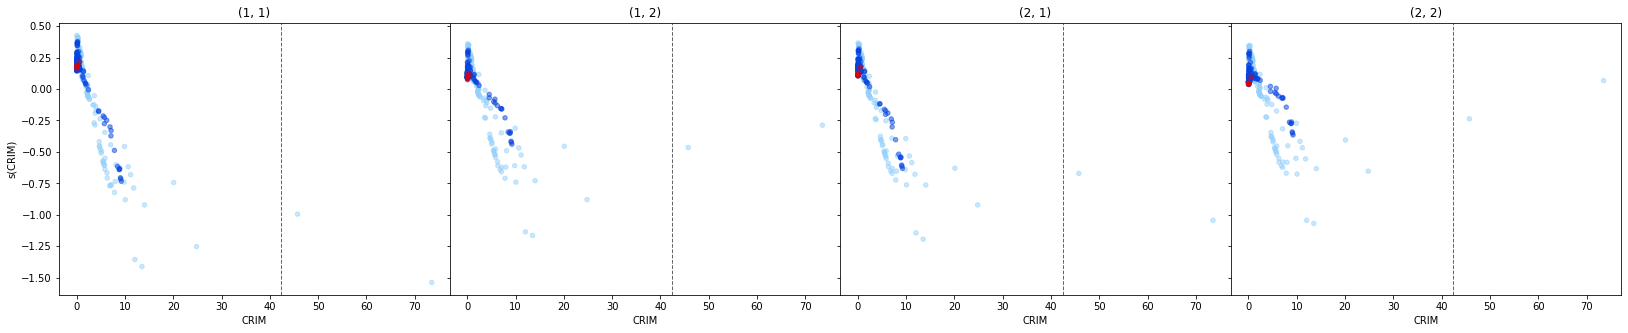

5.936 <= RM <= 7.225002872141104
[Upper CF: RM == 8.64 --> {'(2, 2)': 5}]


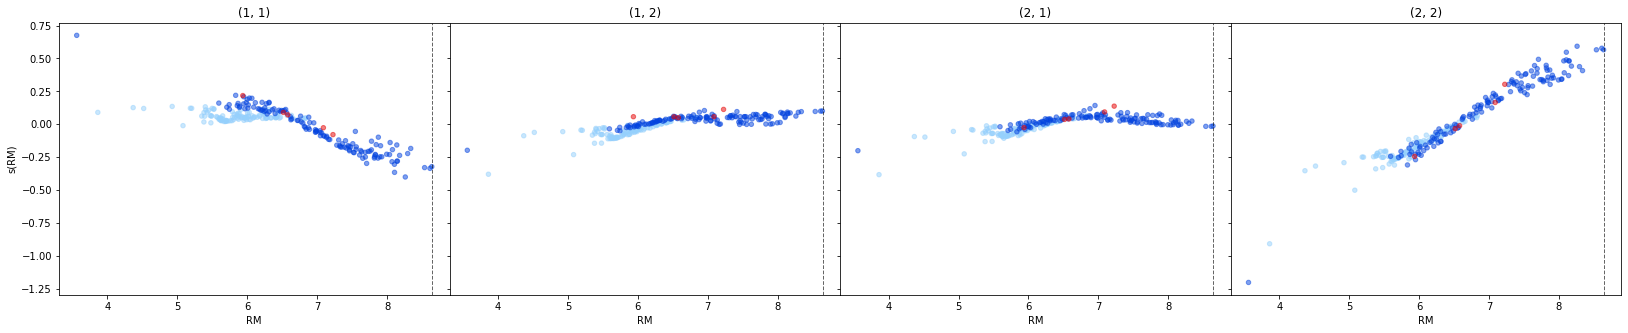

RAD <= 5.0
[Upper CF: RAD == 13.36 --> {'(2, 2)': 5}]


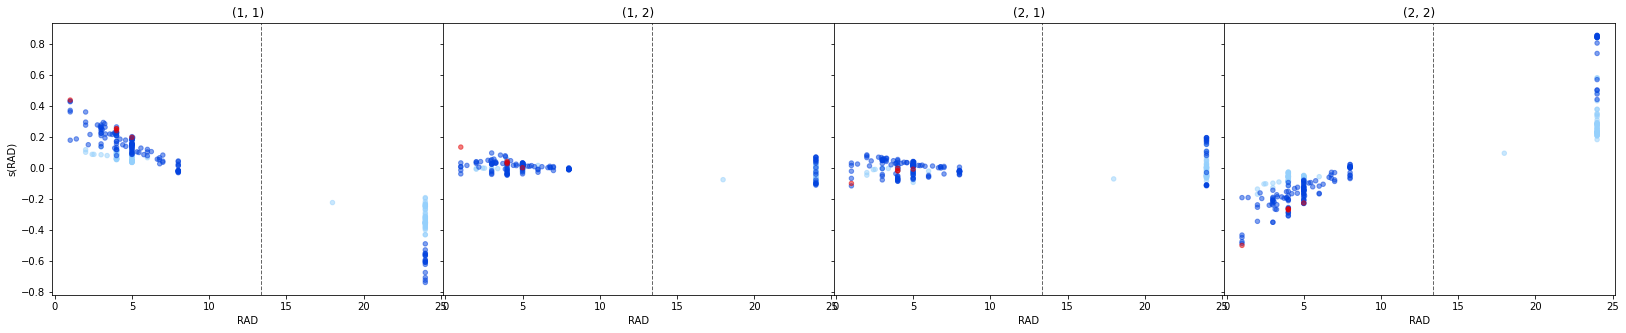

2.1153479553520422 <= DIS
[Lower CF: DIS == 1.94 --> {'(2, 2)': 5}]


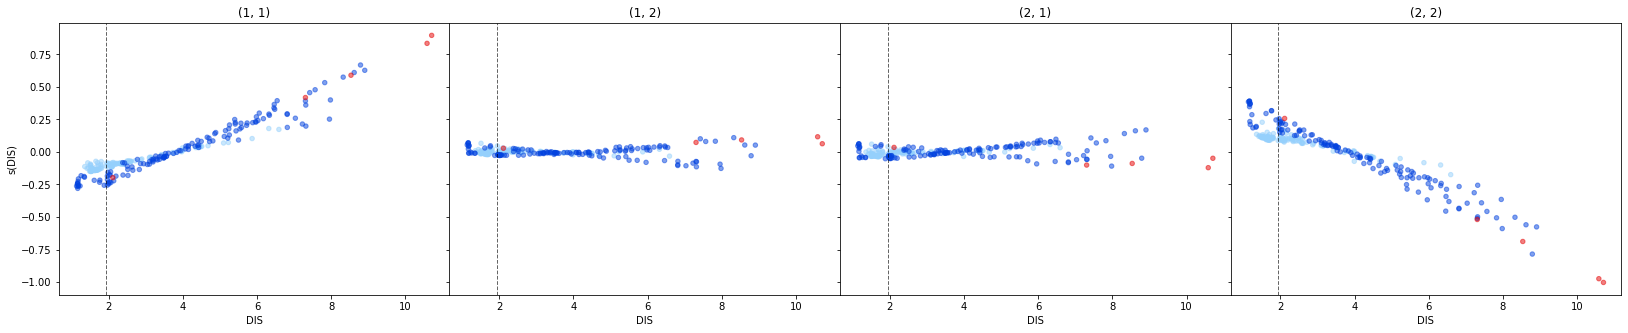

AGE <= 1.0
[Upper CF: AGE == 2.0 --> {'(2, 2)': 5}]


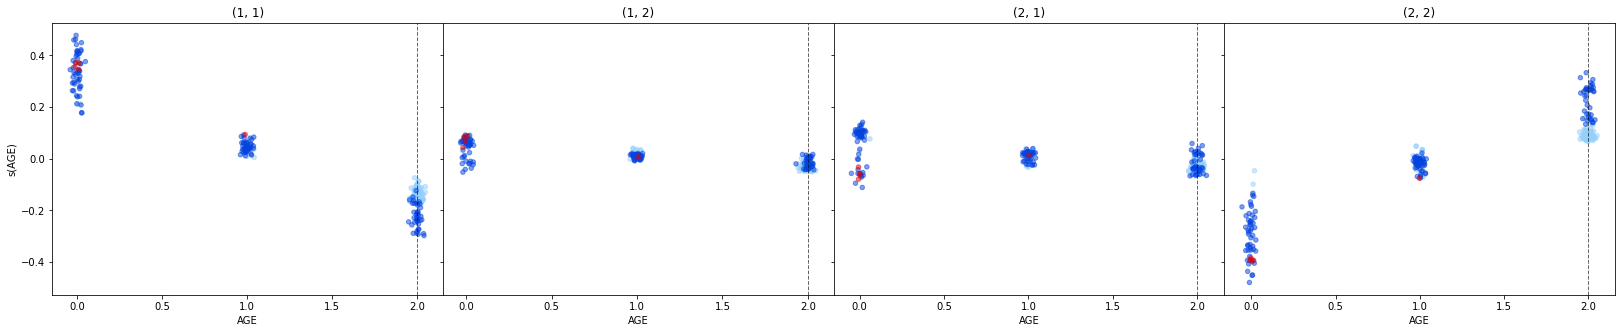

264.0 <= TAX <= 411.0
[]


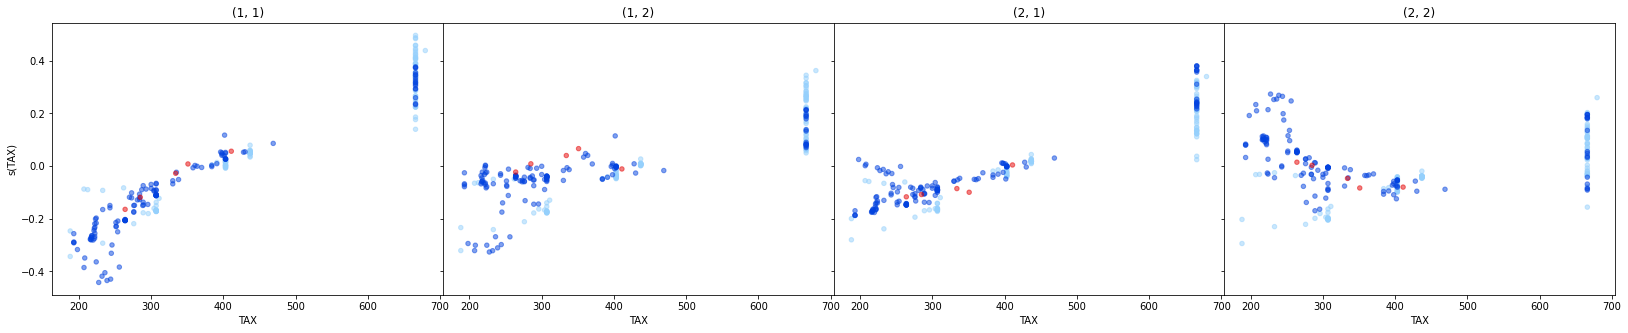

PTRATIO
[]


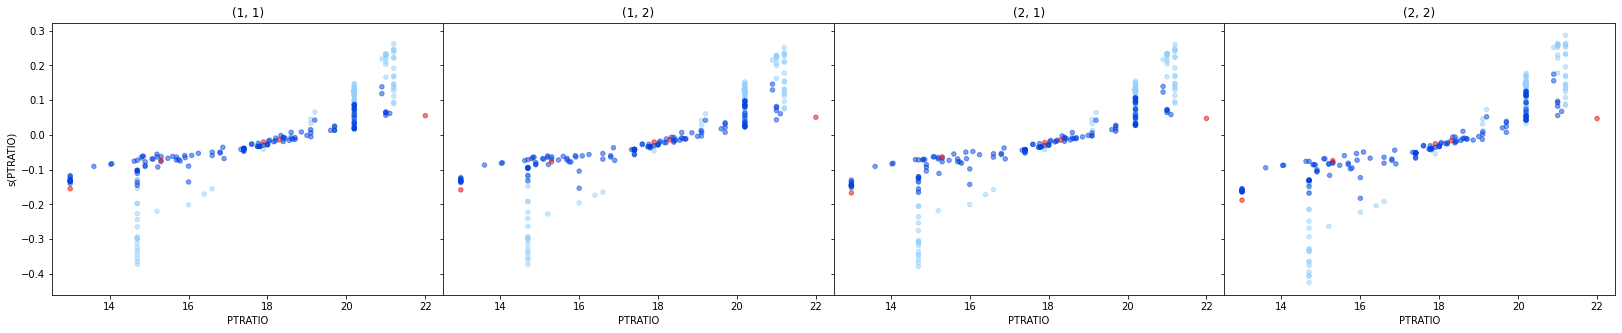

0.4 <= NOX <= 0.647
[]


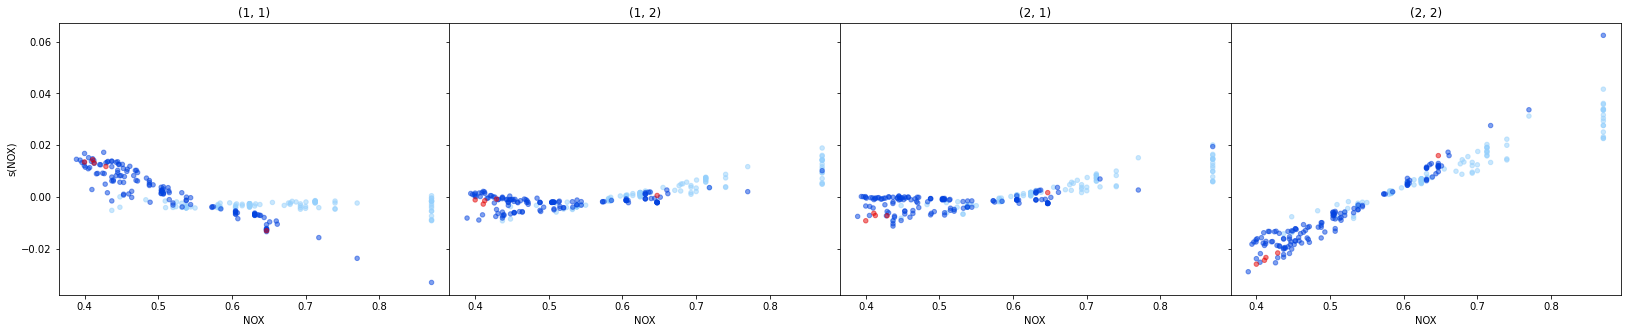

In [36]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True);

## $(2,1)$

In [70]:
node = load('(2, 1)')
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (1, 0)     2
 (2, 1)     2
 dtype: int64,
 149.33968539846273)

### Main Node

In [71]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRL,
 (2, 2)    11
 (1, 1)    10
 (2, 1)     2
 dtype: int64,
 20.214452806269755)

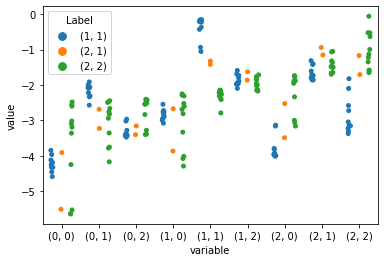

In [51]:
node.plot_outcomes()

In [52]:
print(node.rule_from_counterfactuals()[0])

6.05 < LSTAT <= 7.41 and CRIM <= 8.6 and 9.80 < INDUS <= 19.61 and ZN <= 18 and DIS <= 4.17 and AGE > 1 and RM <= 7.17


6.48 <= LSTAT <= 7.12
[Lower CF: LSTAT == 6.05 --> {'(2, 2)': 2},
 Upper CF: LSTAT == 7.42 --> {'(1, 1)': 2}]


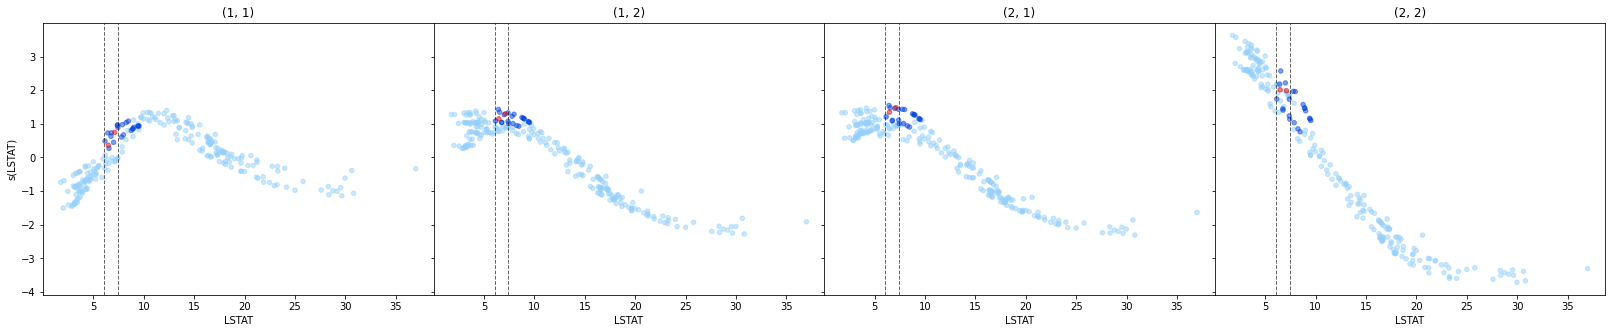

0.10959 <= CRIM <= 4.55587
[Upper CF: CRIM == 8.7 --> {'(2, 2)': 1, '(2, 0)': 1}]


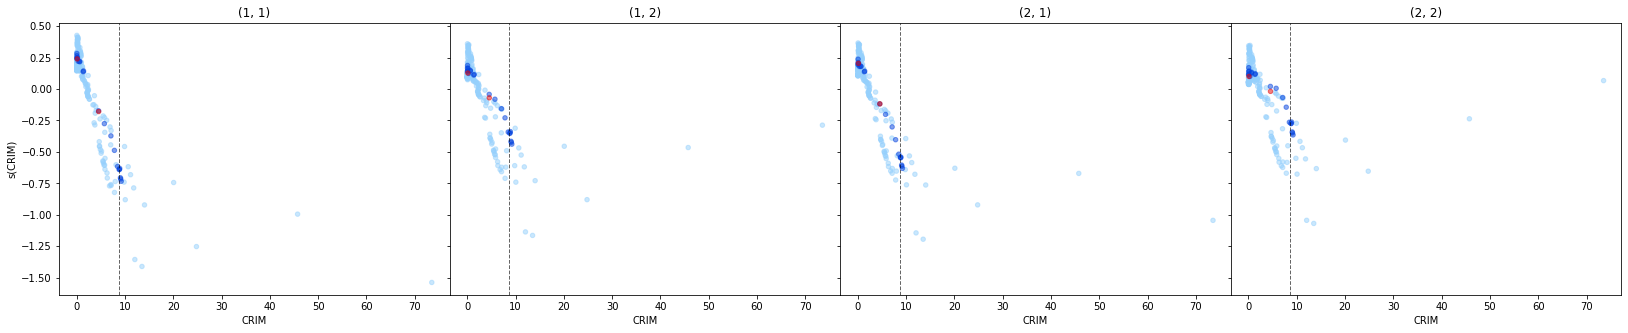

RAD
[]


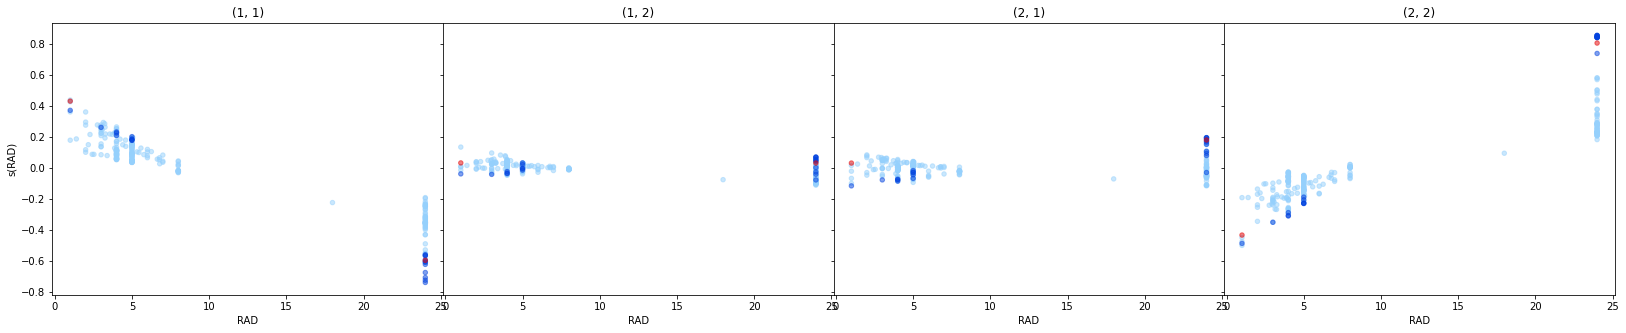

11.93 <= INDUS <= 18.1
[Lower CF: INDUS == 9.8 --> {'(2, 2)': 2},
 Upper CF: INDUS == 19.62 --> {'(1, 1)': 2}]


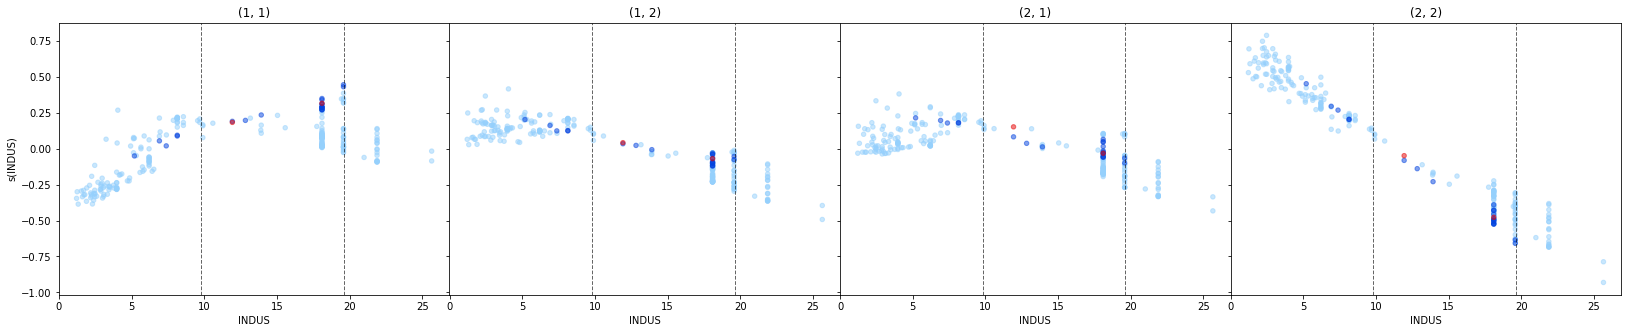

ZN == 0.0
[Upper CF: ZN == 19.0 --> {'(2, 2)': 2}]


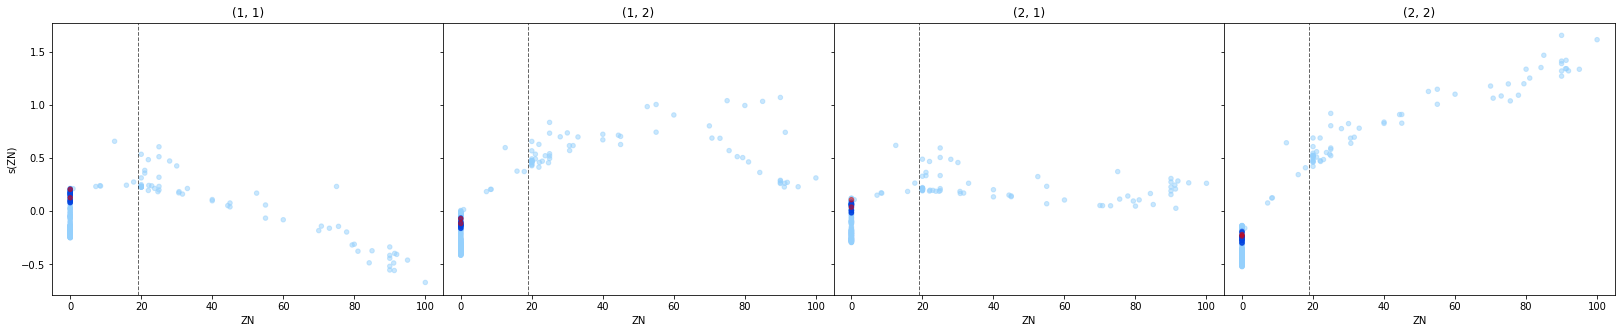

273.0 <= TAX <= 666.0
[]


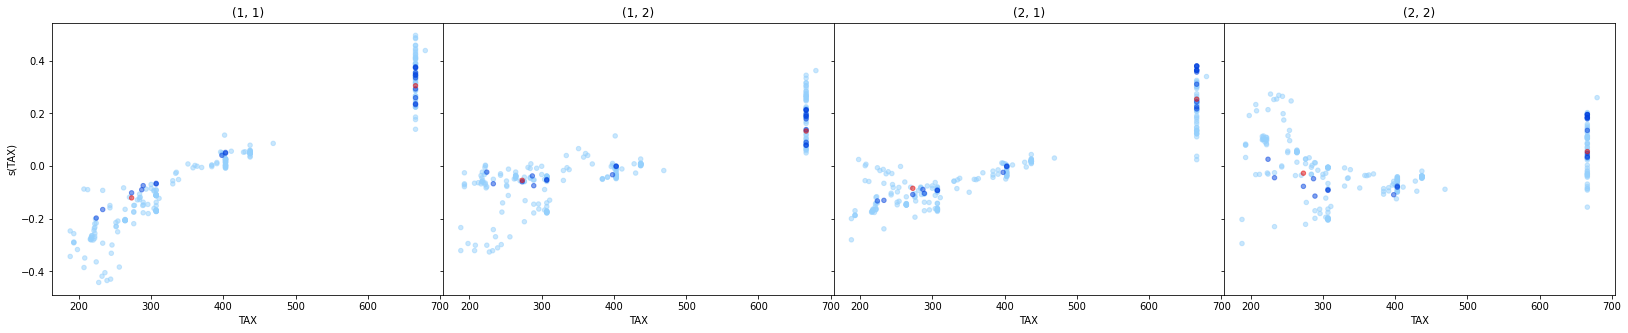

1.6132 <= DIS <= 2.3889
[Upper CF: DIS == 4.18 --> {'(1, 1)': 2}]


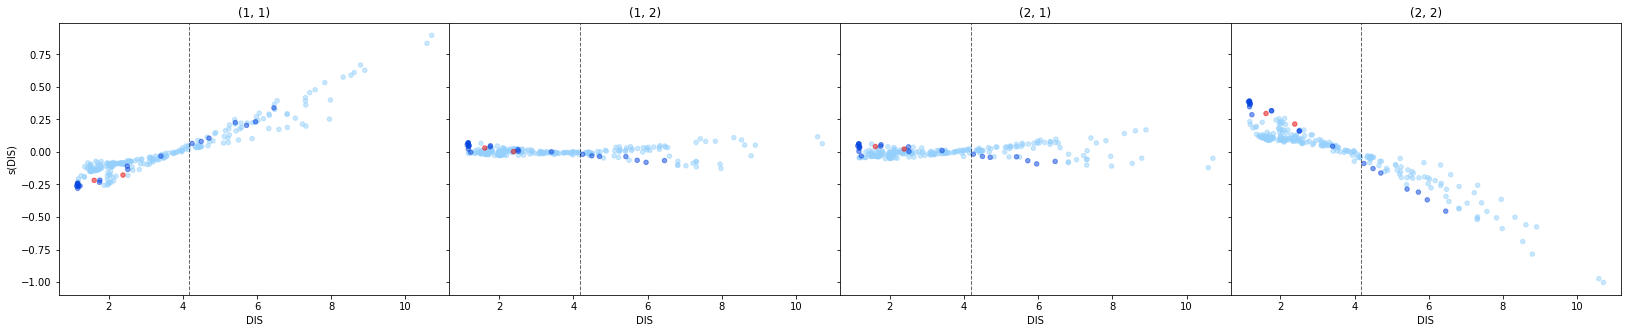

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 2}]


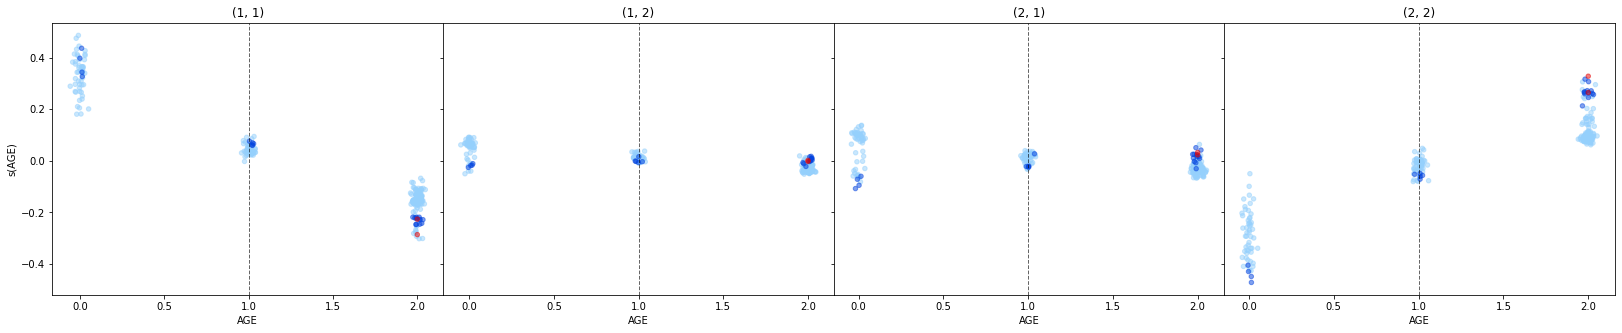

RM <= 6.794
[Upper CF: RM == 7.18 --> {'(2, 2)': 2}]


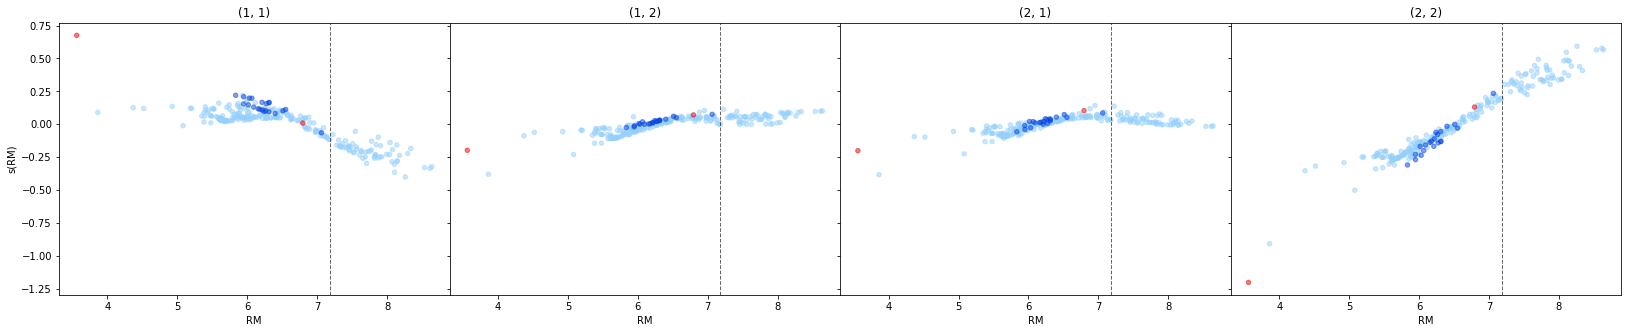

20.2 <= PTRATIO <= 21.0
[]


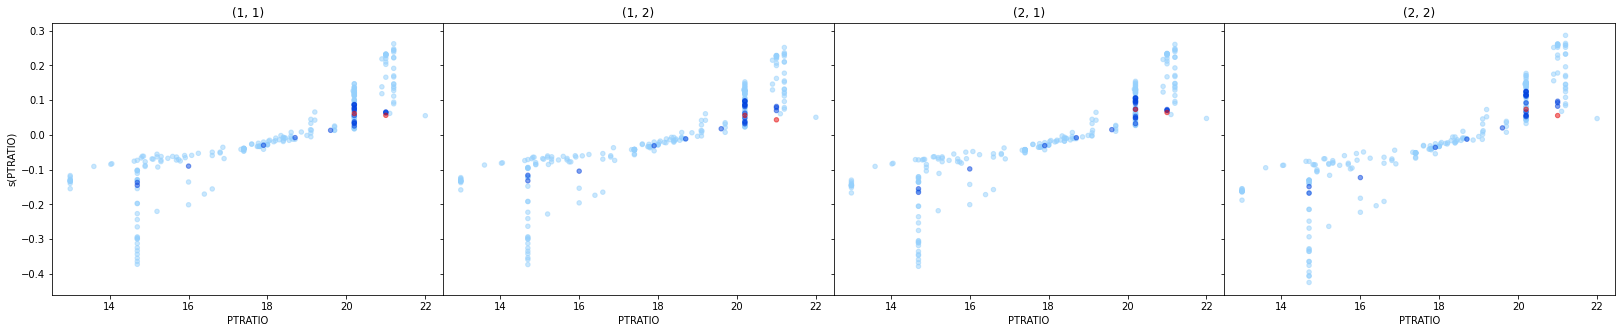

0.573 <= NOX <= 0.718
[]


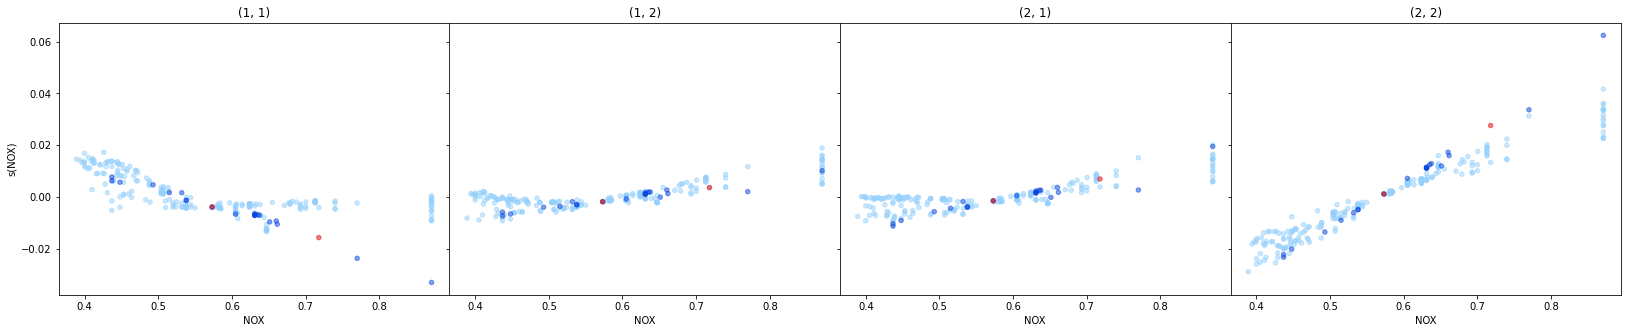

In [53]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True);

### Node 1

In [72]:
path = [node]
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRLLLL,
 (2, 1)    1
 dtype: int64,
 0)

In [73]:
node.data['CRIM']

101    0.10959
Name: CRIM, dtype: float64

In [74]:
node = node.parent
node, node.class_counts, node.distance

(RRLLL,
 (1, 1)    2
 (2, 1)    1
 dtype: int64,
 3.4950491236614525)

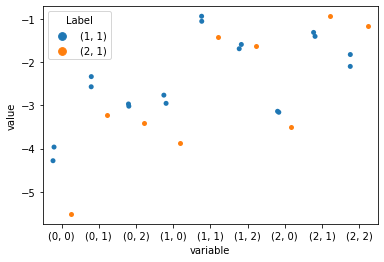

In [75]:
node.plot_outcomes()

In [76]:
print(node.rule_from_counterfactuals()[0])

6.05 < LSTAT <= 7.31 and 9.80 < INDUS <= 16.31 and AGE > 1 and ZN <= 6 and RAD <= 3.23 and 1.44 < DIS <= 4.17 and CRIM <= 2.2 and 6.06 < RM <= 7.17


CRIM == 0.10959
[Upper CF: CRIM == 2.3 --> {'(2, 2)': 1}]


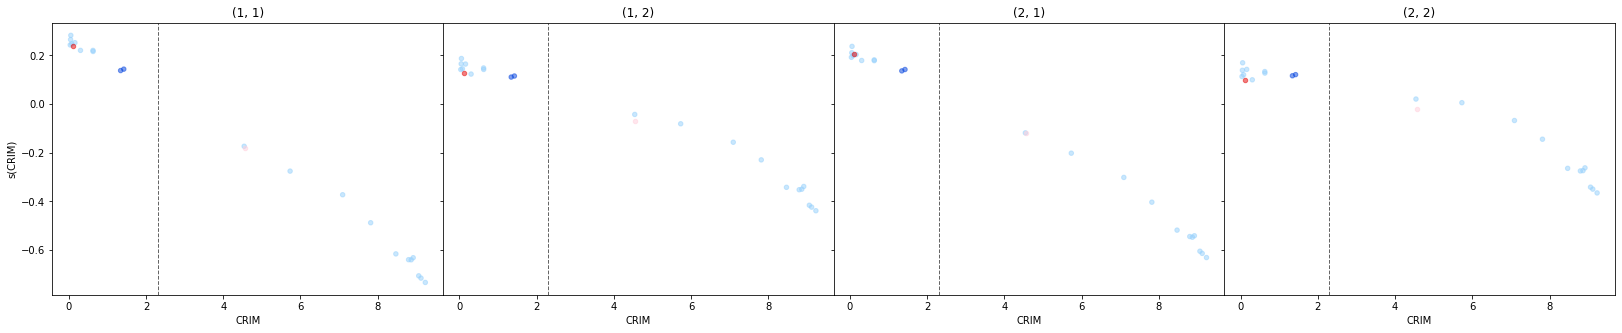

In [78]:
path[-1].plot_feature_dependence('CRIM', focus=node, classes=classes, print_stats=True);

### Node 2

In [79]:
node = path[-1].right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRLRRL,
 (2, 1)    1
 dtype: int64,
 0)

In [80]:
node.data['CRIM']

34    4.55587
Name: CRIM, dtype: float64

In [81]:
node = node.parent
node, node.class_counts, node.distance

(RRLRR,
 (2, 2)    4
 (2, 1)    1
 dtype: int64,
 8.85158144778508)

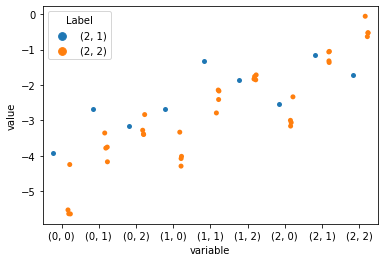

In [82]:
node.plot_outcomes()

In [83]:
print(node.rule_from_counterfactuals()[0])

6.06 < LSTAT <= 7.41 and RAD > 22.57 and 10.73 < INDUS <= 19.61 and RM <= 4.53 and 0.3 < CRIM <= 8.6 and TAX > 301 and ZN <= 18 and DIS <= 2.24 and AGE > 1 and PTRATIO > 13.03


LSTAT == 7.12
[Lower CF: LSTAT == 6.06 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 7.42 --> {'(1, 1)': 1}]


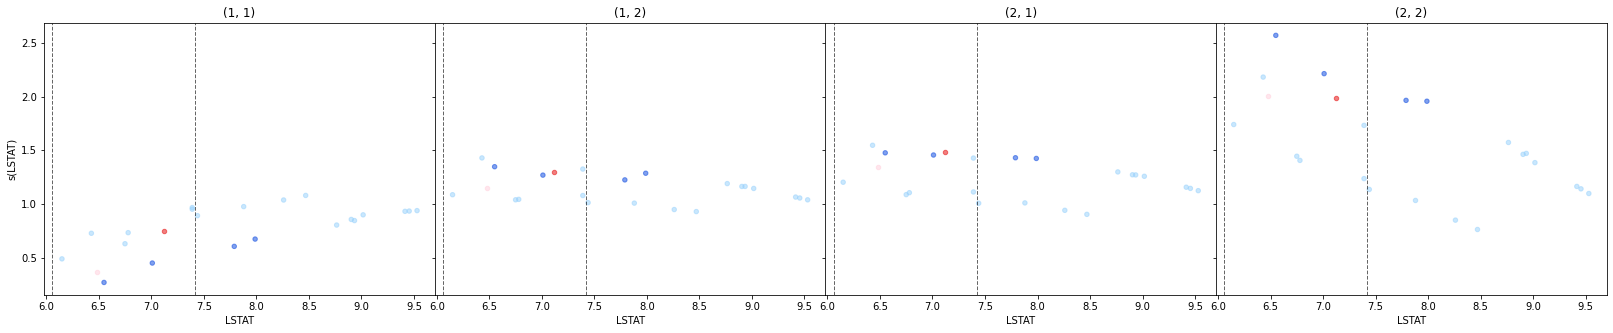

In [85]:
path[-1].plot_feature_dependence('LSTAT', focus=node, classes=classes, print_stats=True);

RM == 3.561
[Upper CF: RM == 4.54 --> {'(2, 2)': 1}]


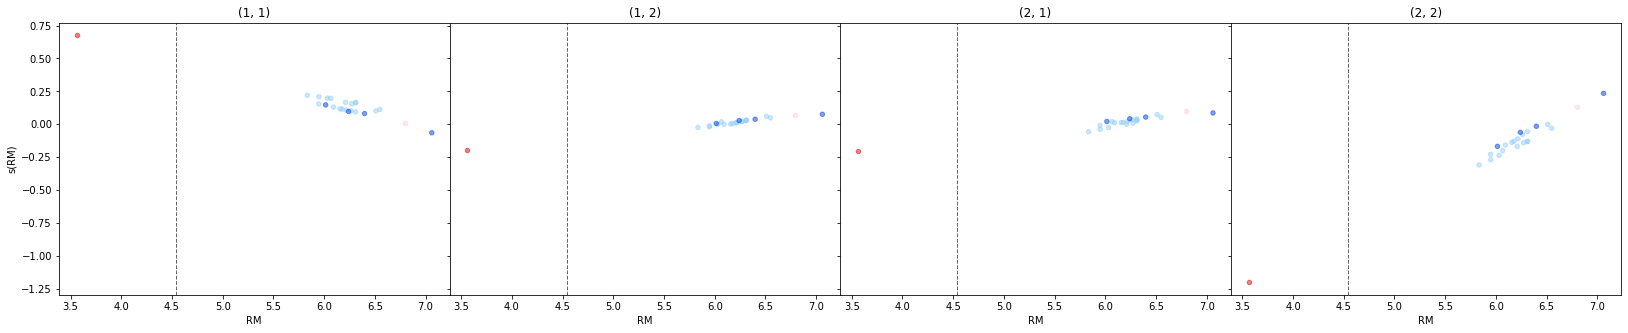

In [86]:
path[-1].plot_feature_dependence('RM', focus=node, classes=classes, print_stats=True);

LSTAT == 7.12
[Lower CF: LSTAT == 6.06 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 7.42 --> {'(1, 1)': 1}]


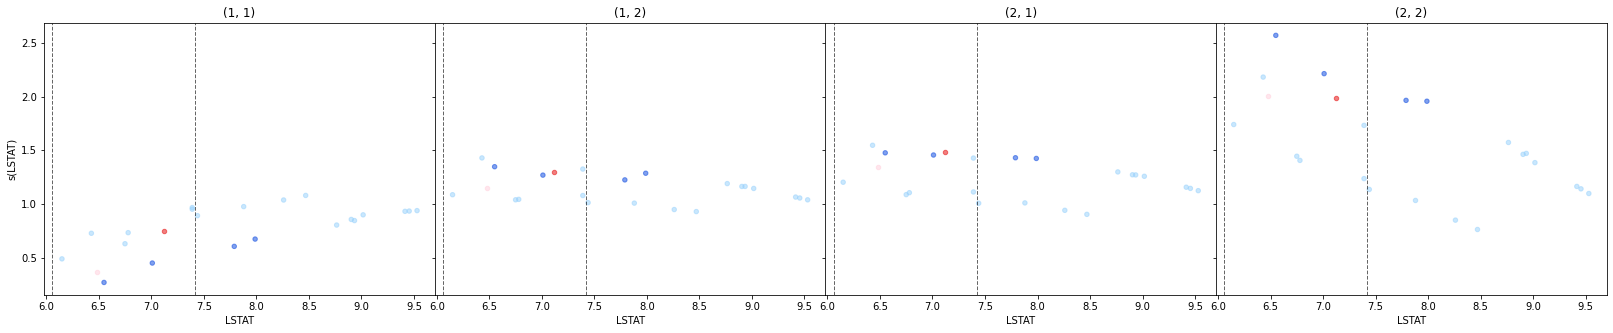

RAD == 24.0
[Lower CF: RAD == 22.57 --> {'(1, 1)': 1}]


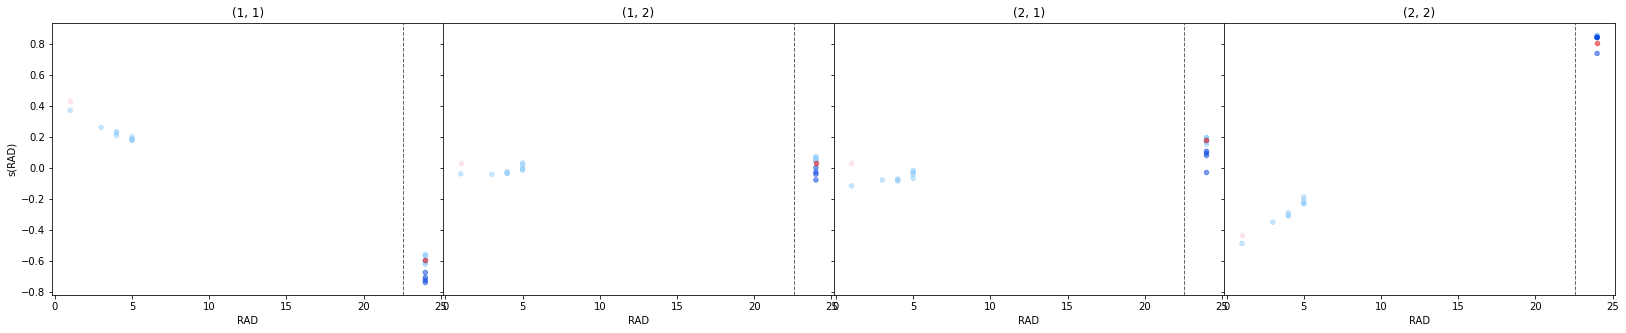

INDUS == 18.1
[Lower CF: INDUS == 10.73 --> {'(2, 2)': 1},
 Upper CF: INDUS == 19.62 --> {'(1, 1)': 1}]


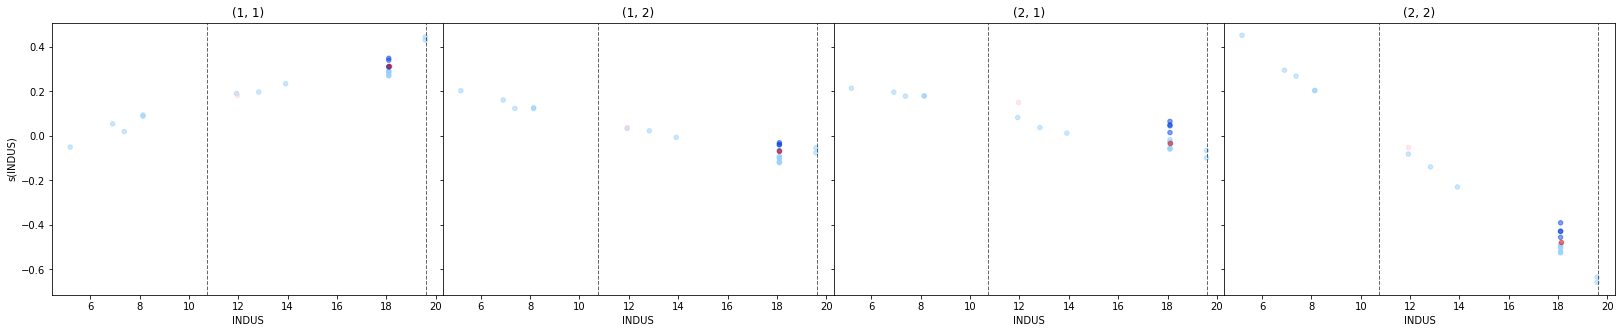

RM == 3.561
[Upper CF: RM == 4.54 --> {'(2, 2)': 1}]


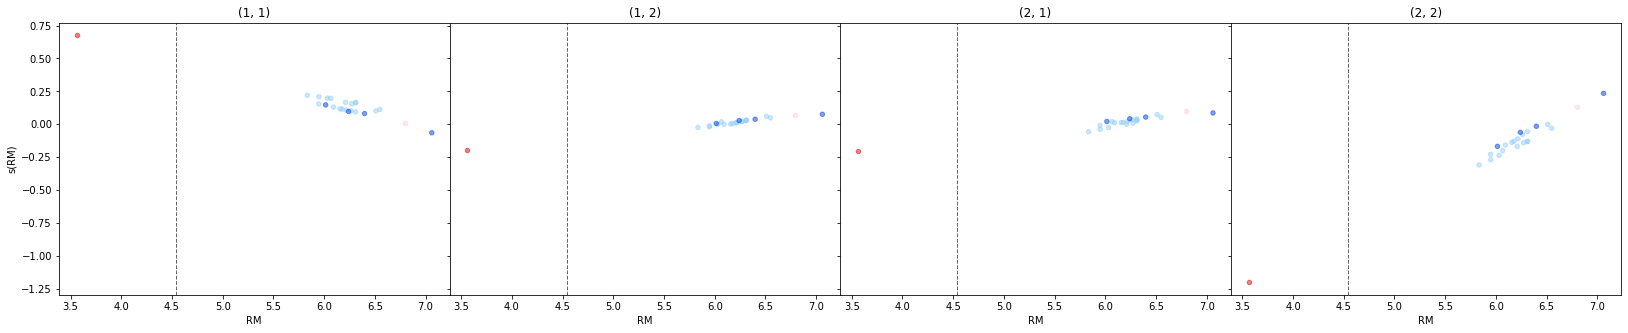

CRIM == 4.55587
[Lower CF: CRIM == 0.3 --> {'(1, 1)': 1},
 Upper CF: CRIM == 8.7 --> {'(2, 0)': 1}]


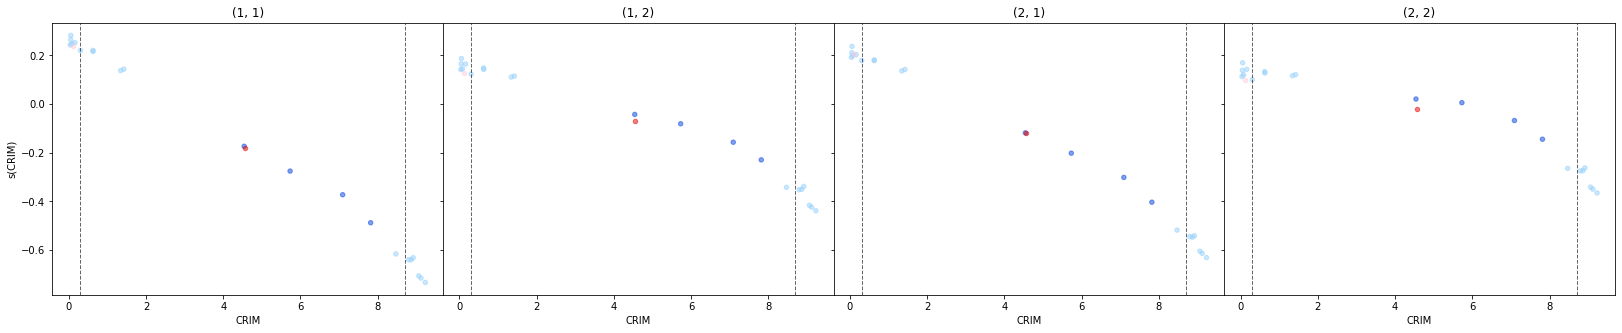

TAX == 666.0
[Lower CF: TAX == 301.0 --> {'(1, 1)': 1}]


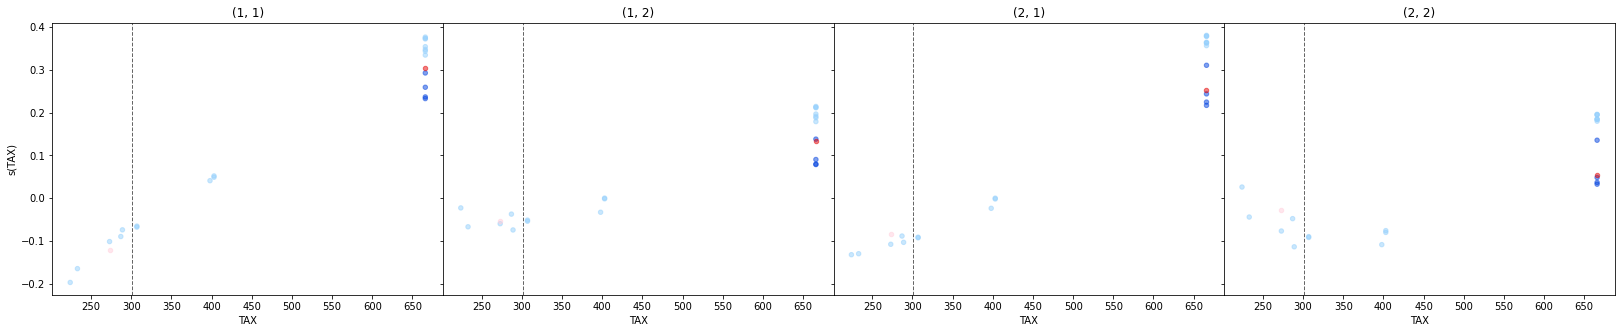

ZN == 0.0
[Upper CF: ZN == 19.0 --> {'(2, 2)': 1}]


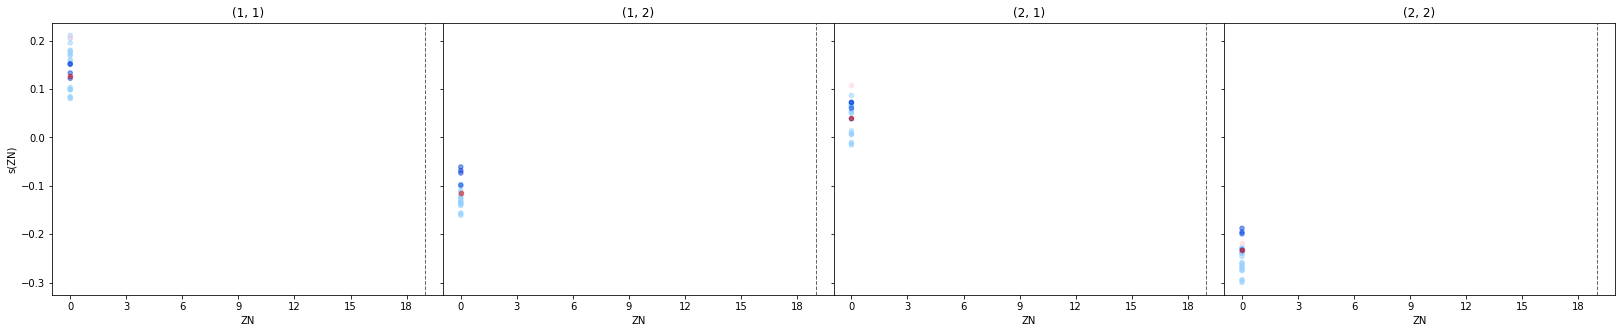

DIS == 1.6132
[Upper CF: DIS == 2.25 --> {'(1, 1)': 1}]


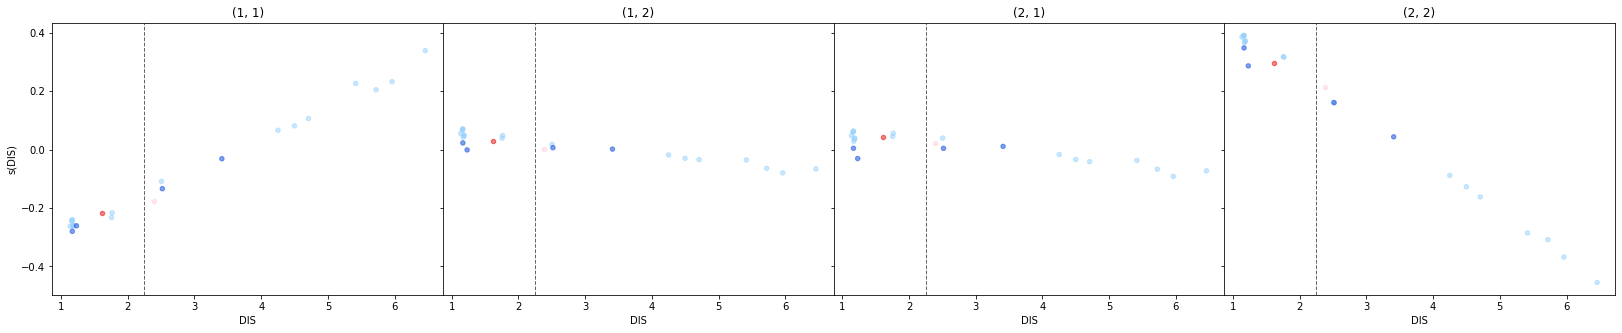

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 1}]


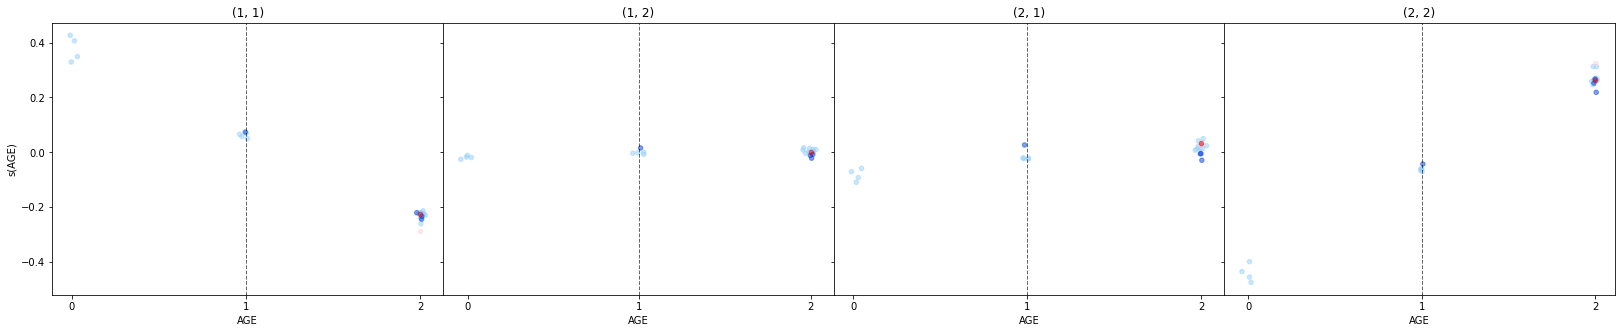

PTRATIO == 20.2
[Lower CF: PTRATIO == 13.03 --> {'(1, 1)': 1}]


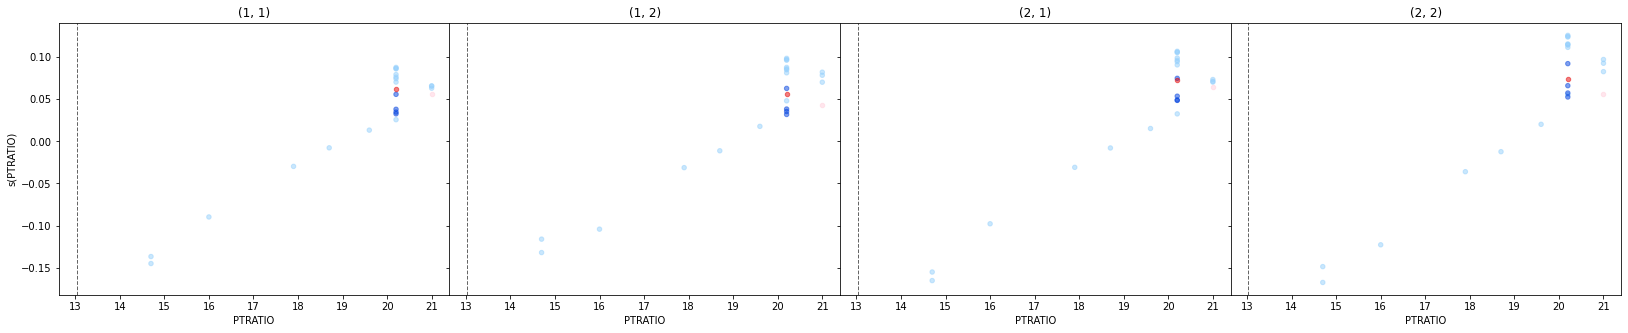

NOX == 0.718
[]


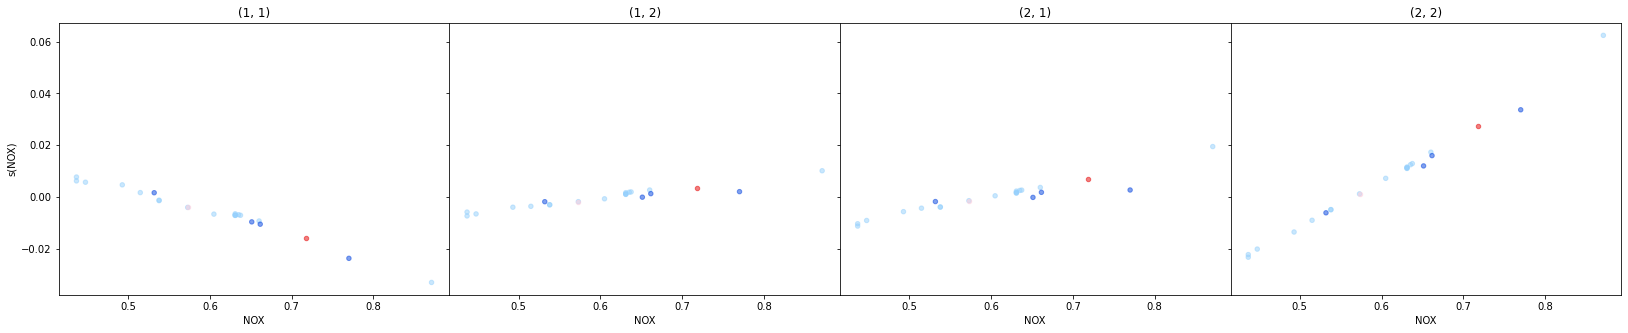

In [87]:
path[-1].plot_feature_dependence(focus=node, classes=classes, print_stats=True);

# Additional Plots

In [10]:
with open('explanations/indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [11]:
node = make_clustering(comparer, indiv_shap_values, categorical_features=categorical_features)

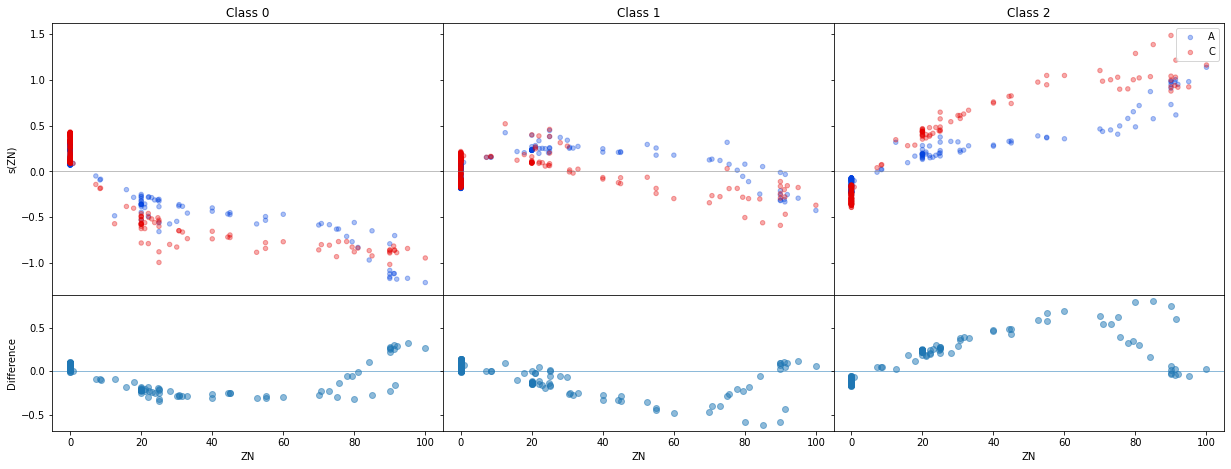

In [15]:
compare_indiv_dep_plots(node, 'ZN')
plt.savefig('figures/boston4-indiv-depplots-zn.pdf', bbox_inches='tight')

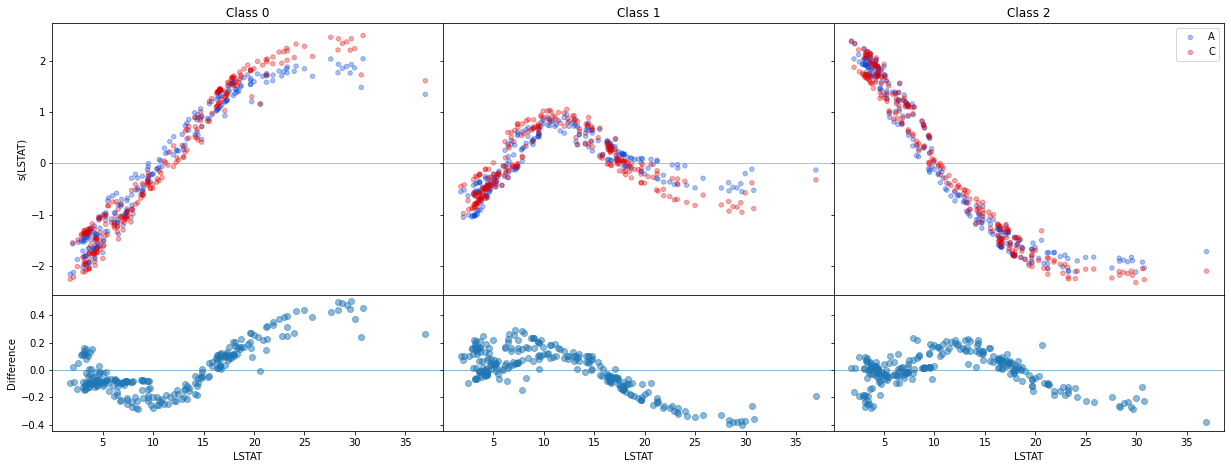

In [16]:
compare_indiv_dep_plots(node, 'LSTAT')
plt.savefig('figures/boston4-indiv-depplots-lstat.pdf', bbox_inches='tight')

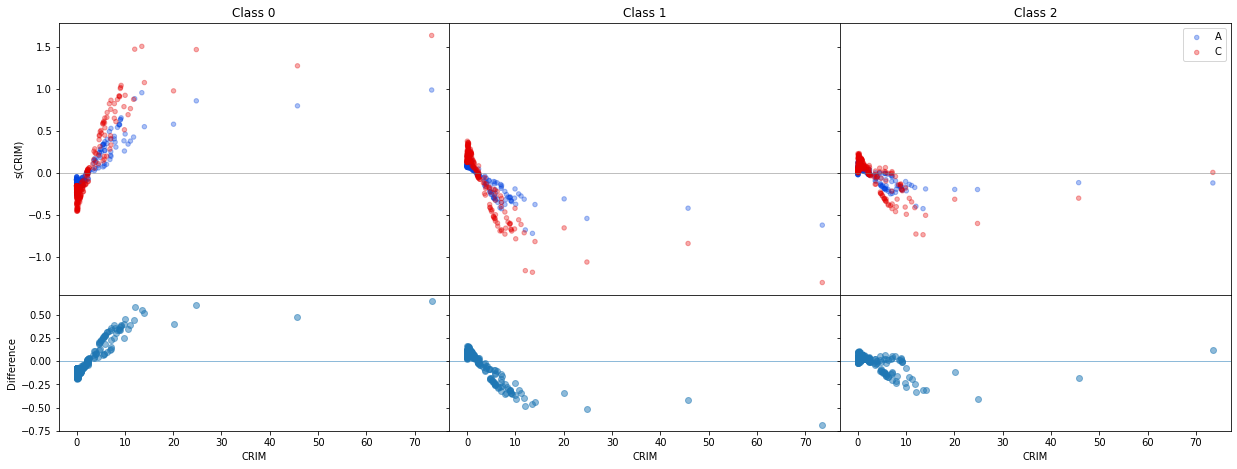

In [17]:
compare_indiv_dep_plots(node, 'CRIM')
plt.savefig('figures/boston4-indiv-depplots-crim.pdf', bbox_inches='tight')

In [45]:
root = load('(0, 1)')
classes = ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']

In [46]:
focus = root.get_last_child_before_focus_class_split()
focus

LRR

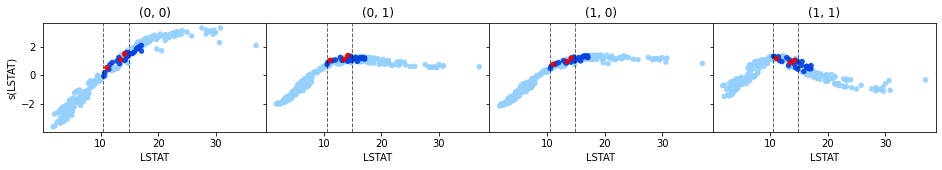

In [47]:
root.plot_feature_dependence('LSTAT', classes=classes, focus=focus, alpha=0.9, figsize=(4, 2), show=False)
plt.savefig('figures/boston4-depplots-01-lstat.pdf', bbox_inches='tight')

In [16]:
root = load('(1, 0)')
classes = ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']

In [38]:
focus = root.get_last_child_before_focus_class_split().get_parent(8)
focus

LRR

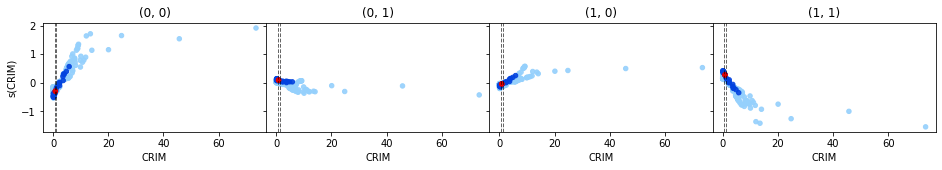

In [41]:
root.plot_feature_dependence('CRIM', classes=classes, focus=focus, alpha=0.9, figsize=(4, 2), show=False)
plt.savefig('figures/boston4-depplots-10-crim-global.pdf', bbox_inches='tight')

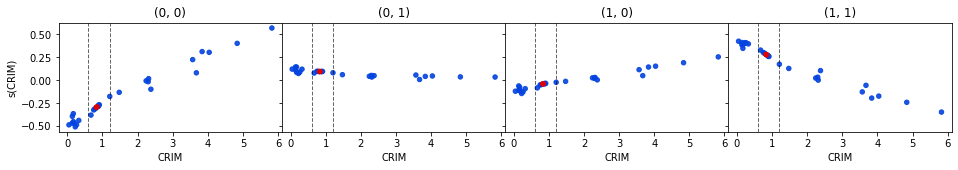

In [42]:
focus.plot_feature_dependence('CRIM', classes=classes, focus=focus, alpha=0.9, figsize=(4, 2), show=False)
plt.savefig('figures/boston4-depplots-10-crim-local.pdf', bbox_inches='tight')

In [48]:
root = load('(1, 2)')
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']

In [49]:
focus = root.get_last_child_before_focus_class_split()
focus

R

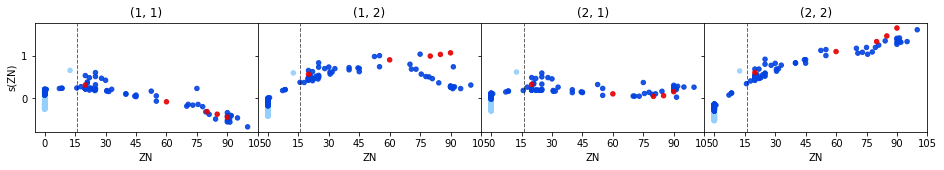

In [50]:
root.plot_feature_dependence('ZN', classes=classes, focus=focus, alpha=0.9, figsize=(4, 2), show=False)
plt.savefig('figures/boston4-depplots-12-zn.pdf', bbox_inches='tight')

In [51]:
root = load('(2, 1)')
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']

In [94]:
focus = root.get_last_child_before_focus_class_split()
focus

RRL

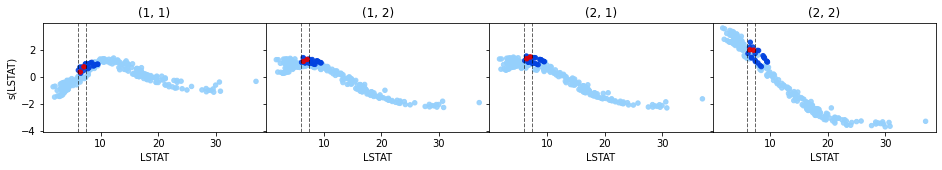

In [95]:
root.plot_feature_dependence('LSTAT', classes=classes, focus=focus, alpha=0.9, figsize=(4, 2), show=False)
plt.savefig('figures/boston4-depplots-21-lstat.pdf', bbox_inches='tight')

In [96]:
path = [focus]
focus = focus.left.get_last_child_before_focus_class_split()
focus, focus.data['CRIM']

(RRLLLL,
 101    0.10959
 Name: CRIM, dtype: float64)

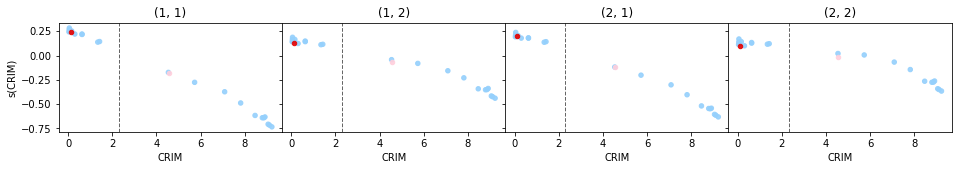

In [97]:
path[-1].plot_feature_dependence('CRIM', focus=focus, classes=classes, alpha=0.9, figsize=(4, 2), show=False)
plt.savefig('figures/boston4-depplots-21-crim.pdf', bbox_inches='tight')

In [98]:
focus = path[-1].right.get_last_child_before_focus_class_split()
focus, focus.data['CRIM']

(RRLRRL,
 34    4.55587
 Name: CRIM, dtype: float64)

In [99]:
focus.data['RM']

34    3.561
Name: RM, dtype: float64

In [100]:
pd.Series(comparer.predict_combined_proba(focus.data)[0], index=indiv_shap_values.output_names)

A.0    0.124074
A.1    0.408421
A.2    0.467506
C.0    0.158212
C.1    0.513467
C.2    0.328321
dtype: float64

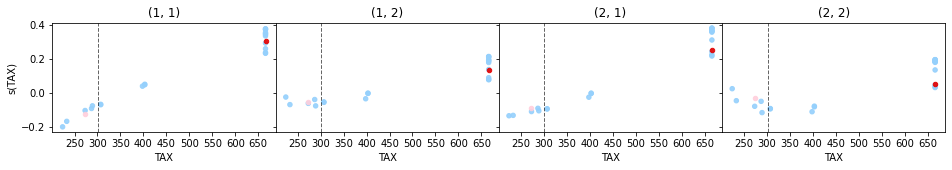

In [104]:
path[-1].plot_feature_dependence('TAX', focus=focus, classes=classes, alpha=0.9, figsize=(4, 2), show=False)
plt.savefig('figures/boston4-depplots-21-tax.pdf', bbox_inches='tight')

In [106]:
clusters_per_class = {
    '(0, 1)': [''],
    '(1, 0)': [''],
    '(1, 2)': [''],
    '(2, 1)': ['', 'RRLLLL', 'RRLRRL'],
}

In [107]:
constraints = []
for label, clusters in clusters_per_class.items():
    root = load(label)
    for cluster in clusters:
        rule, constraint, _ = root.get(cluster).rule_from_counterfactuals(latex=True)
        print(f'\item \emph{{Class {label}, cluster {cluster}:}} ${rule}$')
        constraints.append(constraint)

\item \emph{Class (0, 1), cluster :} $10.48 < \text{LSTAT} \leq 14.89 \land \text{ZN} \leq 1 \land 12.37 < \text{INDUS} \leq 22.10 \land \text{CRIM} \leq 4.3 \land 4.81 < \text{RM} \leq 7.33 \land \text{AGE} > 0 \land \text{DIS} \leq 6.59 \land 13.36 < \text{PTRATIO} \leq 20.73$
\item \emph{Class (1, 0), cluster :} $16.33 < \text{LSTAT} \leq 16.71 \land \text{ZN} \leq 0 \land 7.13 < \text{INDUS} \leq 9.14 \land 0.6 < \text{CRIM} \leq 1.1 \land 5.22 < \text{RM} \leq 5.75 \land \text{RAD} \leq 5.93 \land 288 < \text{TAX} \leq 326 \land \text{AGE} > 1 \land \text{DIS} > 2.93 \land 20.58 < \text{PTRATIO} \leq 21.38$
\item \emph{Class (1, 2), cluster :} $3.58 < \text{LSTAT} \leq 11.58 \land \text{ZN} > 16 \land \text{INDUS} \leq 16.12 \land \text{CRIM} \leq 42.3 \land \text{RM} \leq 8.63 \land \text{RAD} \leq 13.35 \land \text{AGE} \leq 1 \land \text{DIS} > 1.94$
\item \emph{Class (2, 1), cluster :} $6.05 < \text{LSTAT} \leq 7.41 \land \text{ZN} \leq 18 \land 9.80 < \text{INDUS} \leq 19.61 

In [108]:
get_complexity(constraints)

Rules           6
Constraints    71
dtype: int64